In [306]:
import os
import io
from io import BytesIO
import ast
from dotenv import load_dotenv
from pinecone import Pinecone
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import pymupdf
import base64
from pydantic import BaseModel, Field
from typing import Literal, List

from langchain.chat_models import init_chat_model
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain_pinecone.vectorstores import PineconeVectorStore
from langchain_openai import OpenAIEmbeddings

load_dotenv()

# Convert cropped_img numpy array to base64 PNG
from PIL import Image


def numpy_to_base64_png(img_array):
    """
    Convert a numpy image array to base64 PNG string

    Args:
        img_array: numpy array representing the image

    Returns:
        str: base64 encoded PNG string
    """
    # Convert numpy array to PIL Image
    if img_array.ndim == 3:
        # RGB image
        pil_img = Image.fromarray(img_array.astype("uint8"))
    else:
        # Grayscale image
        pil_img = Image.fromarray(img_array.astype("uint8"), mode="L")

    # Convert PIL Image to PNG bytes
    png_buffer = io.BytesIO()
    pil_img.save(png_buffer, format="PNG")
    png_bytes = png_buffer.getvalue()

    # Convert PNG bytes to base64
    base64_string = base64.b64encode(png_bytes).decode("utf-8")

    return base64_string


def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(
                lines[i + 1 :]
            )  # Remove everything before "```json"
            json_output = json_output.split("```")[
                0
            ]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

## Utils

In [2]:
# Parse PDF page to image
plans_pdf = "/Users/shenghan/Code/scopeiq-ai-backend/files/Unorganised/60492284-DRG-EL-5001-T4.pdf"
plans_pdf = Path(plans_pdf)
page_num = 1
output_page_image = plans_pdf.stem + f"_{page_num}.png"

doc = pymupdf.open(str(plans_pdf))
page = doc[page_num - 1]

dpi = 300
scale = dpi / 72.0
matrix = pymupdf.Matrix(scale, scale)

pix = page.get_pixmap(matrix=matrix)
width_px, height_px = pix.width, pix.height
print(f"PDF dimensions: {width_px}x{height_px} pixels")

png_bytes = pix.tobytes("png")

with open(output_page_image, "wb") as f:
    f.write(png_bytes)
print(f"PNG saved to: {output_page_image}")

PDF dimensions: 9933x7016 pixels
PNG saved to: 60492284-DRG-EL-5001-T4_1.png


## Text Document Understanding

In [307]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

pc = Pinecone(api_key=os.environ["PINECONE_API_KEY"])
# pc_index = pc.Index(os.environ["PINECONE_INDEX_NAME"])
pc_index = pc.Index("scopeiq-documents-test")

vector_store = PineconeVectorStore(index=pc_index, embedding=embeddings)

In [ ]:
# pc.delete_index("scopeiq-documents-test")

In [310]:
from pinecone import (
    Pinecone,
    ServerlessSpec,
    CloudProvider,
    AwsRegion,
    Metric,
    DeletionProtection,
    VectorType,
)

pc.create_index("scopeiq-documents-test", dimension=1536,
        spec=ServerlessSpec(
            cloud=CloudProvider.AWS,
            region=AwsRegion.US_EAST_1
        ))

{
    "name": "scopeiq-documents-test",
    "metric": "cosine",
    "host": "scopeiq-documents-test-rkqm097.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "vector_type": "dense",
    "dimension": 1536,
    "deletion_protection": "disabled",
    "tags": null
}

In [ ]:
# pc_index.delete(delete_all=True)

NotFoundException: (404)
Reason: Not Found
HTTP response headers: HTTPHeaderDict({'Date': 'Wed, 29 Oct 2025 14:12:20 GMT', 'Content-Type': 'application/json', 'Content-Length': '55', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '70', 'x-pinecone-request-id': '8864727015400791369', 'x-envoy-upstream-service-time': '71', 'server': 'envoy'})
HTTP response body: {"code":5,"message":"Namespace not found","details":[]}


In [ ]:
# results = vector_store.similarity_search_with_score(
#     "tiles", k=3, namespace="ce24c27b-80e6-46a7-bc71-d3b1f418cef7"
# )
# results

[]

In [108]:
# embed PDF file
from langchain_community.document_loaders import PyPDFLoader

file_path = "/Users/shenghan/Code/scopeiq-ai-backend/15_0112 North Projects Bill of Quantities_150112.pdf"
loader = PyPDFLoader(file_path)
pages = []
async for page in loader.alazy_load():
    # print(len(page.page_content))
    pages.append(page)

In [ ]:
from langchain_docling import DoclingLoader

loader = DoclingLoader(
    file_path="/Users/shenghan/Desktop/Copy_BLOG DRAFT_Main_of FSxN 180_ Well-architected storage with WF.docx",
)
docling_pages = []
async for page in loader.alazy_load():
    docling_pages.append(page)
docling_pages[0]

TypeError: DoclingLoader.__init__() got an unexpected keyword argument 'allow_external_plugins'

In [77]:
from langchain_community.document_loaders import UnstructuredWordDocumentLoader

loader = UnstructuredWordDocumentLoader(
    "/Users/shenghan/Desktop/Copy_BLOG DRAFT_Main_of FSxN 180_ Well-architected storage with WF.docx",
    include_page_breaks=True,
    mode="paged",
)

docx_pages = []
async for page in loader.alazy_load():
    # print(len(page.page_content))
    docx_pages.append(page)

print(len(docx_pages))
docx_pages

`mode='paged'` is deprecated in favor of the 'by_page' chunking strategy. Learn more about chunking here: https://docs.unstructured.io/open-source/core-functionality/chunking


2


[Document(metadata={'source': '/Users/shenghan/Desktop/Copy_BLOG DRAFT_Main_of FSxN 180_ Well-architected storage with WF.docx', 'category_depth': 0, 'emphasized_text_contents': ['Tags:'], 'emphasized_text_tags': ['b'], 'file_directory': '/Users/shenghan/Desktop', 'filename': 'Copy_BLOG DRAFT_Main_of FSxN 180_ Well-architected storage with WF.docx', 'last_modified': '2025-06-25T22:13:39', 'page_number': 1, 'languages': ['eng'], 'filetype': 'application/vnd.openxmlformats-officedocument.wordprocessingml.document', 'text_as_html': '<table><tr><td>Customer</td><td>NetApp</td></tr><tr><td>Topic</td><td>FSxN / WLF</td></tr><tr><td>Voice</td><td>Highlight relevant: Formal, technical, casual</td></tr><tr><td>Number of words</td><td>700-1500 (max &lt; 2000), not including code</td></tr><tr><td>Target Audience</td><td>Highlight relevant: IT/storage admin, cloud architect, DevTest/developer, DB admin, ONTAP users (e.g. ONTAP, CVO, etc.)</td></tr><tr><td>Target Sector</td><td>Workload or Vertical

In [50]:
Path(docx_pages[0].metadata['source']).name

'12_kendall_st.docx'

In [54]:
from langchain_community.document_loaders import TextLoader

loader = TextLoader("/Users/shenghan/Code/scopeiq-ai-backend/12_kendall_st.txt")
pages = []
async for page in loader.alazy_load():
    pages.append(page)
pages


[Document(metadata={'source': '/Users/shenghan/Code/scopeiq-ai-backend/12_kendall_st.txt'}, page_content='J.S.Hill Construction p/l\nA.B.N.14693604573\nJarrod@hillphensconstructions.com.au\nJarrod 0447355799\n21st November 2021\n\nAttention: Ross Lillis\n\nProject: 12 Kendall st Essendon\n\nWorks: internal renovations\n\nDemolition\n\n-Remove associated structural timber frame and plasterboard to areas noted on plans. Existing kitchen, pantry and hallway.\n\n-remove plasterwork and structural framing to stair void, to accommodate new works -remove all wall and floor claddings to downstairs bathroom.\n\n-remove linen framing plasterwork and laundry joinery. Remove floor coverings to laundry -saw cut existing concrete slab for new concrete pad-F1 -Remove shelving and joinery from master WIR\n\n-Supply skip bins/ rubbish disposal for all works\n-disconnect electrical and plumbing to existing kitchen\n-kitchen appliances and joinery removed by others\n\nElectrical\n\n-supply and install/re

In [59]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=2000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(pages)

print(f"Split pdf into {len(all_splits)} sub-documents.")

Split pdf into 2 sub-documents.


In [70]:
split = all_splits[0]
split_source = split.metadata["source"]
split_start_idx = split.metadata["start_index"]

In [ ]:
contextual_prompt_str = """<document> 
{whole_page}
</document>
Here is the chunk we want to situate within the whole document 
<chunk> 
{chunk}
</chunk> 
Please give a short succinct context to situate this chunk within the overall document page for the purposes of improving search retrieval of the chunk. Answer only with the succinct context and nothing else."""

llm = init_chat_model(model="gpt-4o-mini", model_provider="openai")
contextual_prompt = ChatPromptTemplate.from_messages([
    ("system", contextual_prompt_str),
])
contextual_chain = contextual_prompt | llm | StrOutputParser()

In [65]:
contextual_chain.invoke(
    {"whole_page": pages[0].page_content, "chunk": all_splits[0].page_content}
)

'The provided chunk is an excerpt from a construction project proposal by J.S. Hill Construction, detailing specific works related to demolition, electrical, and plumbing tasks for internal renovations at 12 Kendall St, Essendon, addressed to client Ross Lillis.'

In [ ]:
contextual_chain.invoke({"whole_page": pages[0].page_content, "chunk": all_splits[0].page_content})

'This chunk details the plumbing, flooring, carpentry, tiling, painting, and inclusions phases of internal renovations specified for the project at 12 Kendall St, Essendon, under the contract with J.S.Hill Construction. It follows the initial demolition and electrical works outlined earlier in the document.'

In [66]:
all_splits

[Document(metadata={'source': '/Users/shenghan/Code/scopeiq-ai-backend/12_kendall_st.txt', 'start_index': 0}, page_content='J.S.Hill Construction p/l\nA.B.N.14693604573\nJarrod@hillphensconstructions.com.au\nJarrod 0447355799\n21st November 2021\n\nAttention: Ross Lillis\n\nProject: 12 Kendall st Essendon\n\nWorks: internal renovations\n\nDemolition\n\n-Remove associated structural timber frame and plasterboard to areas noted on plans. Existing kitchen, pantry and hallway.\n\n-remove plasterwork and structural framing to stair void, to accommodate new works -remove all wall and floor claddings to downstairs bathroom.\n\n-remove linen framing plasterwork and laundry joinery. Remove floor coverings to laundry -saw cut existing concrete slab for new concrete pad-F1 -Remove shelving and joinery from master WIR\n\n-Supply skip bins/ rubbish disposal for all works\n-disconnect electrical and plumbing to existing kitchen\n-kitchen appliances and joinery removed by others\n\nElectrical\n\n-sup

In [75]:
# create uuid
import uuid

new_namespace = str(uuid.uuid4())

# for i, chunk in enumerate(all_splits):
#     chunk.metadata.update(
#         {
#             "document_id": new_namespace,
#         }
#     )

In [6]:
# vector_store = vector_store.from_documents(
#     all_splits, embeddings, index_name=os.environ["PINECONE_INDEX_NAME"]
# )
vector_store = vector_store.from_documents(
    all_splits, embeddings, index_name="scopeiq-documents-large"
)

In [25]:
new_namespace = "30a454c0-a38b-45ec-87e7-79cdfe07884b"

In [109]:
vector_store.add_documents(pages, namespace=new_namespace)

2025-09-13 23:42:44,354 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


['69d83516-270b-424f-be4b-86c427166f05',
 'd06cfc90-e1e7-468c-a6d9-b9eb00e37cfd',
 '511b57d2-19e5-48fc-bf88-42502330be6f',
 'c174336d-fef5-4f9d-8755-3d91874c2cb6',
 '42508f0d-a614-4e0c-a8de-d50cbe7a7b91',
 '3d1fd64c-2dc9-4980-a9d0-e693e499eafc',
 '61b1f572-c0f0-4c35-9cf1-f4cdb3603963',
 'd3bd32cd-4fa9-435f-8f15-59eda7dd171e',
 '20c70d83-993b-477d-89a3-36ac4c232e57',
 'a76e1fde-7ec0-4fcf-a97b-050d4734426f',
 '08637f1b-1814-4b08-a708-46e9657e4a3b',
 '749efa23-9840-4f02-89bd-7f14791db4f2',
 '5a6d089a-eb21-4016-ad7b-cd19eaf16730',
 'dc6a0630-2bea-4d61-93f1-2a24001db518',
 '93c6f395-3435-455f-9da1-e31f1fff9262',
 'aa0bb463-04e3-43f4-8f46-c9ad5a4ac950',
 'f40b0abb-8dd5-445b-863e-14ccfb6d3696',
 '1a2c74c3-f634-4b96-aafd-f1a8b2a83bca',
 '170fb29e-54cc-4190-8a86-2117b278c58b',
 '76bceded-ba89-465d-973a-43327f6729fd',
 'd0e0f1db-53a7-4f4d-ac38-365c4ad41179',
 'efb795a4-95ed-40f9-ae89-be6fa9e1ec58',
 '0350e927-cf5d-4453-86d4-6c4e17d1380d',
 '47c1b7ef-11c7-4957-93c6-f0f162f78beb',
 '788e8349-9098-

In [110]:
retriever = vector_store.as_retriever(
    search_type="mmr",
    search_kwargs={"k": 10},
)

In [102]:
new_namespace

'30a454c0-a38b-45ec-87e7-79cdfe07884b'

In [45]:
retriever.invoke(
    "kendall street",
    namespace=new_namespace,
)

[Document(metadata={'source': '/Users/shenghan/Code/scopeiq-ai-backend/12_kendall_st.docx', 'start_index': 0.0}, page_content='J.S.Hill Construction p/l\n\nA.B.N.14693604573\n\nJarrod@hillphensconstructions.com.au\n\nJarrod 0447355799\n\n21st November 2021\n\nAttention: Ross Lillis\n\nProject: 12 Kendall st Essendon\n\nWorks: internal renovations\n\nDemolition\n\nRemove associated structural timber frame and plasterboard to areas noted on plans. Existing kitchen, pantry and hallway.\n\nremove plasterwork and structural framing to stair void, to accommodate new works -remove all wall and floor claddings to downstairs bathroom.\n\nremove linen framing plasterwork and laundry joinery. Remove floor coverings to laundry -saw cut existing concrete slab for new concrete pad-F1 -Remove shelving and joinery from master WIR\n\nSupply skip bins/ rubbish disposal for all works\n\ndisconnect electrical and plumbing to existing kitchen\n\nkitchen appliances and joinery removed by others\n\nElectrica

In [78]:
# add BM25
from pinecone_text.sparse import BM25Encoder

# or from pinecone_text.sparse import SpladeEncoder if you wish to work with SPLADE

# use default tf-idf values
bm25_encoder = BM25Encoder().default()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/shenghan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


KeyboardInterrupt: 

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
import re

# download resources (only run once)
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

# ----------------------------
# 1. Preprocessing function
# ----------------------------
def preprocess_text(raw_text):
    # split into paragraphs/sentences (granularity depends on your use case)
    docs = sent_tokenize(raw_text)  # you can also split by '\n\n' for paragraphs

    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words("english"))
    corpus = []

    for doc in docs:
        # lowercase & remove non-alphanumeric chars
        doc = doc.lower()
        doc = re.sub(r"[^a-z0-9\s]", " ", doc)

        # tokenize
        tokens = word_tokenize(doc)

        # remove stopwords & lemmatize
        tokens = [
            lemmatizer.lemmatize(token)
            for token in tokens
            if token not in stop_words and len(token) > 2
        ]
        if tokens:  # avoid empty docs
            corpus.append(tokens)

    return corpus

In [ ]:
corpus = preprocess_text(pdf_text)

# fit tf-idf values on your corpus
bm25_encoder.fit(corpus)

# store the values to a json file
bm25_encoder.dump("bm25_values.json")

# load to your BM25Encoder object
bm25_encoder = BM25Encoder().load("bm25_values.json")

In [111]:
rag_system_prompt = """You are an AI assistant specialized in construction and jobsite document analysis.

# Instructions
- Answer strictly in concise points.
- Do not repeat or paraphrase the question.
- Do not add context or commentary.
- For questions that are ambiguous, provide all related information you can find regarding material type, specifications or measurements.
- For questions about the number of items, provide exact numbers based on the structured analysis results.
- For dimensional queries, reference specific measurements and specifications found in the analysis.
- For spatial queries (adjacent, inside, north, south, etc), use the spatial relationship information to provide accurate location-based answers.
- Base your answer on the specific information provided in the context.
- If the context is empty, please mention it in your answer. Do not make up an answer.

Context: 
{context}"""

In [112]:
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

rag_llm = init_chat_model(model="gpt-4o", model_provider="openai")
rag_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", rag_system_prompt),
        ("user", "{question}"),
    ]
)

# Define state for application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
    project_id: str


# Define application steps
def retrieve(state: State):
    print("--retrieve--")
    project_id = state["project_id"]
    print(project_id)
    retrieved_docs = retriever.invoke(state["question"], namespace=project_id)
    return {"context": retrieved_docs}


def generate(state: State):
    print("--generate--")
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = rag_prompt.invoke(
        {"question": state["question"], "context": docs_content}
    )
    response = rag_llm.invoke(messages)
    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [113]:
project_id = "30a454c0-a38b-45ec-87e7-79cdfe07884b"
res = graph.invoke({"question": "what is the color of the stone bench tops", "project_id": new_namespace})
print(res["answer"])

--retrieve--
30a454c0-a38b-45ec-87e7-79cdfe07884b


2025-09-13 23:43:09,059 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


--generate--


2025-09-13 23:43:13,234 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


The stone bench tops are Reconstituted Essa Stone Bone White gloss finish for Levels 1 to 20, and Themus Stone honed finish for Sub-Penthouse Level 21 to 22 and Penthouse Apartment Level 23.


In [81]:
# read single_file_evals.json
import json
with open("single_file_evals.json", "r") as f:
    evals = json.load(f)

for eval in evals:
    print(eval["question"])
    res = graph.invoke(
        {
            "question": eval["question"],
            "project_id": new_namespace,
        }
    )
    print("pred: ", res["answer"])
    print("groundtruth: ", eval["answer"])
    print("-" * 100)


How thick is the blinding?
--retrieve--
13dec143-b993-4187-a66f-7bf1c596d88b
--generate--
pred:  The blinding is 50mm thick.
groundtruth:  50mm thick free draining sand blinding
----------------------------------------------------------------------------------------------------
What is the Ground Floor concrete slab?
--retrieve--
13dec143-b993-4187-a66f-7bf1c596d88b
--generate--
pred:  - Sides of raft slabs: 21 m²
- Sides of ground and edge beams: 494 m²
groundtruth:  40N Reinforced Concrete in ground slab, 180mm thick
----------------------------------------------------------------------------------------------------
What's the internal blockwork walls
--retrieve--
13dec143-b993-4187-a66f-7bf1c596d88b
--generate--
pred:  - 150 thick internal core fill concrete blockwork 5m high including wall stiffeners: 458 m²
- 250 thick internal core fill concrete blockwork 5m high including wall stiffeners: 66 m²
groundtruth:  150 thick internal core fill concrete blockwork 5m high including wall 

## Stage 1: Legend Detection with VLM

In [3]:
from dotenv import load_dotenv
import pymupdf
import base64

load_dotenv()

True

In [3]:
plans_pdf = "/Users/shenghan/Code/scopeiq-ai-backend/files/28 St Clems Rd Doncaster East - Working Drawings.pdf"
# plans_pdf = "/Users/shenghan/Code/scopeiq-ai-backend/files/2018950 CURRENT ECP1of2 REV A WITH ENERGY STAMP - 141 CHARLES ST NORTHCOTE VIC 3070.pdf"
# plans_pdf = "/Users/shenghan/Code/scopeiq-ai-backend/files/Fw_ 17 Cappella St Balwyn North/17 Cappella St Balwyn North - Working drawings.pdf"
doc = pymupdf.open(plans_pdf)
pdf_bytes = doc.tobytes()

# check paper size
print(f"MediaBox: {doc[0].mediabox}")
print(f"CropBox: {doc[0].cropbox}")
print(f"Rotation: {doc[0].rotation}") # 90: landscape
width_points = doc[0].mediabox.width
height_points = doc[0].mediabox.height
print(f"Width: {width_points} points")
print(f"Height: {height_points} points")

# convert points to pixels
# A1 size (594 × 841 mm / 23.4 × 33.1 inches)
# A2 size (420 × 594 mm / 16.5 × 23.4 inches)
# A3 size (297 × 420 mm / 11.7 × 16.5 inches)
# A4 size (210 × 297 mm / 8.3 × 11.7 inches)
width_inches = width_points / 72.0
height_inches = height_points / 72.0
print(f"Width: {width_inches} inches")
print(f"Height: {height_inches} inches")

MediaBox: Rect(0.0, 0.0, 1684.0, 2384.0)
CropBox: Rect(0.0, 0.0, 1684.0, 2384.0)
Rotation: 90
Width: 1684.0 points
Height: 2384.0 points
Width: 23.38888888888889 inches
Height: 33.111111111111114 inches


In [ ]:
page_num = 7
doc_page = doc[page_num - 1]

# pg7.pdf: PDF dimensions: 4963x3509 pixels
# .pdf: PDF dimensions: 9934x7017 pixels

# choose DPI (e.g., 144 dpi). 72 dpi is 1:1 with PDF points 
# can be 150, 300, 600
dpi = 300 # 300
scale = dpi / 72.0
matrix = pymupdf.Matrix(scale, scale)

pix = doc_page.get_pixmap(matrix=matrix)
width_px, height_px = pix.width, pix.height
print(f"PDF dimensions: {width_px}x{height_px} pixels")

png_bytes = pix.tobytes("png")

PDF dimensions: 9934x7017 pixels


In [5]:
# Write PNG bytes to file
output_file = "28 St Clems Rd Doncaster East - Working Drawings pg7.png"
with open(output_file, "wb") as f:
    f.write(png_bytes)
print(f"PNG saved to: {output_file}")

PNG saved to: 28 St Clems Rd Doncaster East - Working Drawings pg7.png


In [4]:
# convert whatever to 4963x3509
page_num = 7
doc_page = doc[page_num - 1]

# Your page dimensions (accounting for 90° rotation)
# After rotation, the page is 2384 x 1684 points (landscape)
page_width = height_points  # After rotation
page_height = width_points  # After rotation

# Target pixel dimensions
target_width = 4963
target_height = 3509

# Calculate scaling factors
scale_x = target_width / page_width
scale_y = target_height / page_height
# scale = scale_x

print(f"Scale factors: x={scale_x:.4f}, y={scale_y:.4f}")

# Create matrix with calculated scaling
matrix = pymupdf.Matrix(scale_x, scale_y)
pix = doc_page.get_pixmap(matrix=matrix)

print(f"Result: {pix.width} x {pix.height} pixels")

png_bytes = pix.tobytes("png")

Scale factors: x=2.0818, y=2.0837
Result: 4963 x 3509 pixels


In [ ]:
# pg7 original points
# 1191x842 (A3 size)
# after scaling to 300 DPI
# 4963x3509
# img shape
# 4963x3509
# without high res setting

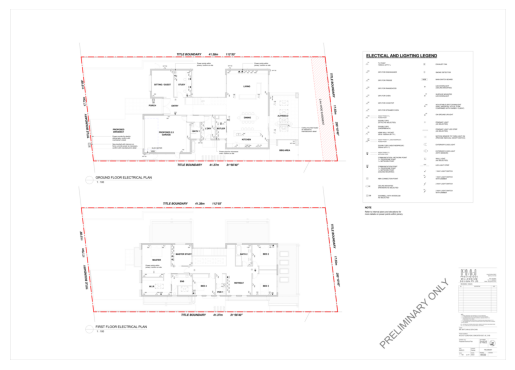

(3509, 4963, 3)


In [7]:
# display pix
# Get raw pixel buffer (not PNG)
buf = pix.samples  # or: pix.samples_memoryview() in newer PyMuPDF

# Determine channels
channels = (pix.n + 1) if pix.alpha else pix.n  # e.g., RGB=3, RGBA=4, Gray=1

# Build array
img = np.frombuffer(buf, dtype=np.uint8).reshape(pix.height, pix.width, channels)

# Optionally drop alpha if present
if channels == 4:
    img = img[:, :, :3]

plt.imshow(img, cmap=None if img.ndim == 3 and img.shape[2] != 1 else "gray")
plt.axis("off")
plt.show()

print(img.shape)

In [ ]:

# llm = init_chat_model("openai:gpt-4.1")
# llm = init_chat_model("google_genai:gemini-2.5-flash")
llm = init_chat_model(
    # "qwen2.5-vl-72b-instruct",
    "qwen3-vl-235b-a22b-instruct",
    model_provider="openai",
    base_url="https://dashscope-intl.aliyuncs.com/compatible-mode/v1",
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    # extra_body={"vl_high_resolution_images": True},
)

class BoundingBox(BaseModel):
    x0: float = Field(description="The x coordinate of the top left corner of the bounding box")
    y0: float = Field(description="The y coordinate of the top left corner of the bounding box")
    x1: float = Field(description="The x coordinate of the bottom right corner of the bounding box")
    y1: float = Field(description="The y coordinate of the bottom right corner of the bounding box")

class DocumentAnalysis(BaseModel):
    # description: str = Field(description="A consice but complete description of the document")
    # category: Literal["plans", "specifications", "other"] = Field(description="The category of the document")
    legend_box: str = Field(description="Summarise what is in the legend box if it exists")
    bounding_boxes: List[BoundingBox] = Field(description="Detected bounding boxes of the legend box if it exists. Assume origin on the top left.")
    # canvas_height: float = Field(description="The height of the canvas in points")
    # canvas_width: float = Field(description="The width of the canvas in points")

message = {
    "role": "user",
    "content": [
        {
            "type": "text",
            # "text": "Describe and classify the category of the document. Also perform detection of the legend box in the document and provide coordinates of bounding box, if it exists. A legend box usually contains a list of symbols and their meanings.",
            # "text": "Perform detection of legend boxes in the document and provide coordinates of bounding box, if it exists. A legend box usually contains a list of symbols and their meanings.",
            # "text": "Perform detection of legend boxes in the document and provide coordinates of bounding box, if it exists. A legend box usually contains a list of symbols and their meanings. There may be multiple legend boxes in one drawing.",
            # "text": "Describe the coordinate system you are trained to use as a model, units and the full dimensions of the image you see. I'm not interested in the contents of the image, more of what you perceive as a multimodal model",
            "text": "Perform detection of legend boxes in the document and provide coordinates of bounding box, if it exists. A legend box usually contains a list of symbols and their meanings. There may be multiple legend boxes in one drawing. Report bbox coordinates in JSON format."
        },
        # {
        #     "type": "file",
        #     "source_type": "base64",
        #     "data": base64.b64encode(pdf_bytes).decode("utf-8"),
        #     "mime_type": "application/pdf",
        #     "filename": "my-file",
        # },
        {
            "type": "image",
            "source_type": "base64",
            "data": base64.b64encode(png_bytes).decode("utf-8"),
            "mime_type": "image/png",
        },
    ],
}
# sllm = llm.with_structured_output(DocumentAnalysis)
response = llm.invoke([message])
print(response)

content='{\n  "legend_boxes": [\n    {\n      "bbox_2d": [716, 120, 934, 548],\n      "label": "ELECTRICAL AND LIGHTING LEGEND"\n    }\n  ]\n}' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 57, 'prompt_tokens': 2579, 'total_tokens': 2636, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': None, 'rejected_prediction_tokens': None, 'text_tokens': 57}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': None, 'image_tokens': 2522, 'text_tokens': 57}}, 'model_name': 'qwen3-vl-235b-a22b-instruct', 'system_fingerprint': None, 'id': 'chatcmpl-24b25f99-acf8-987c-a819-a6fb7f456721', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None} id='run--e8936968-0443-4f50-bf9e-ff358ea0762f-0' usage_metadata={'input_tokens': 2579, 'output_tokens': 57, 'total_tokens': 2636, 'input_token_details': {}, 'output_token_details': {}}


Resized image size: 1280x904


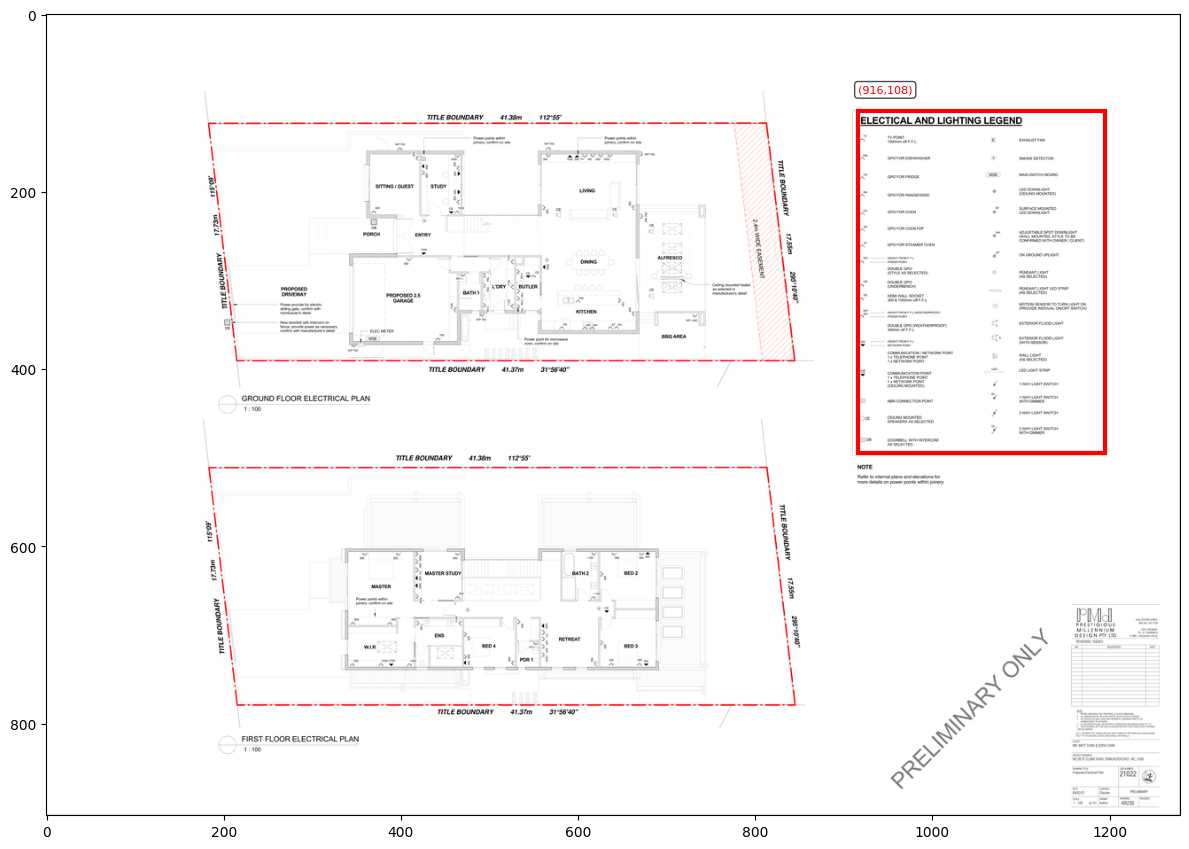

In [58]:
image = Image.open(BytesIO(png_bytes))

image.thumbnail([1280, 1280], Image.Resampling.LANCZOS)
width, height = image.size
print(f"Resized image size: {width}x{height}")

bounding_boxes = response.content
try:
    json_output = ast.literal_eval(bounding_boxes)["legend_boxes"]
except Exception as e:
    end_idx = bounding_boxes.rfind('"}') + len('"}')
    truncated_text = bounding_boxes[:end_idx] + "]"
    json_output = ast.literal_eval(truncated_text)

if not isinstance(json_output, list):
    json_output = [json_output]

cropped_images = []

fig, ax = plt.subplots(figsize=(12, 12))

# Iterate over the bounding boxes
for i, bounding_box in enumerate(json_output):
    # Convert normalized coordinates to absolute coordinates
    abs_y1 = int(bounding_box["bbox_2d"][1] / 1000 * height)
    abs_x1 = int(bounding_box["bbox_2d"][0] / 1000 * width)
    abs_y2 = int(bounding_box["bbox_2d"][3] / 1000 * height)
    abs_x2 = int(bounding_box["bbox_2d"][2] / 1000 * width)

    if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

    if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

    # Crop the bounding box region
    cropped_image = image.crop((abs_x1, abs_y1, abs_x2, abs_y2))
    cropped_images.append(cropped_image)
    ax.add_patch(
        patches.Rectangle(
            (abs_x1, abs_y1), abs_x2 - abs_x1, abs_y2 - abs_y1, linewidth=3, edgecolor="red", facecolor="none"
        )
    )

    ax.text(abs_x1, abs_y1 - 20, f"({abs_x1:.0f},{abs_y1:.0f})", color="red", fontsize=8, bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

ax.imshow(image, origin="upper")
plt.tight_layout()
plt.show()

scale: 4.166666666666667


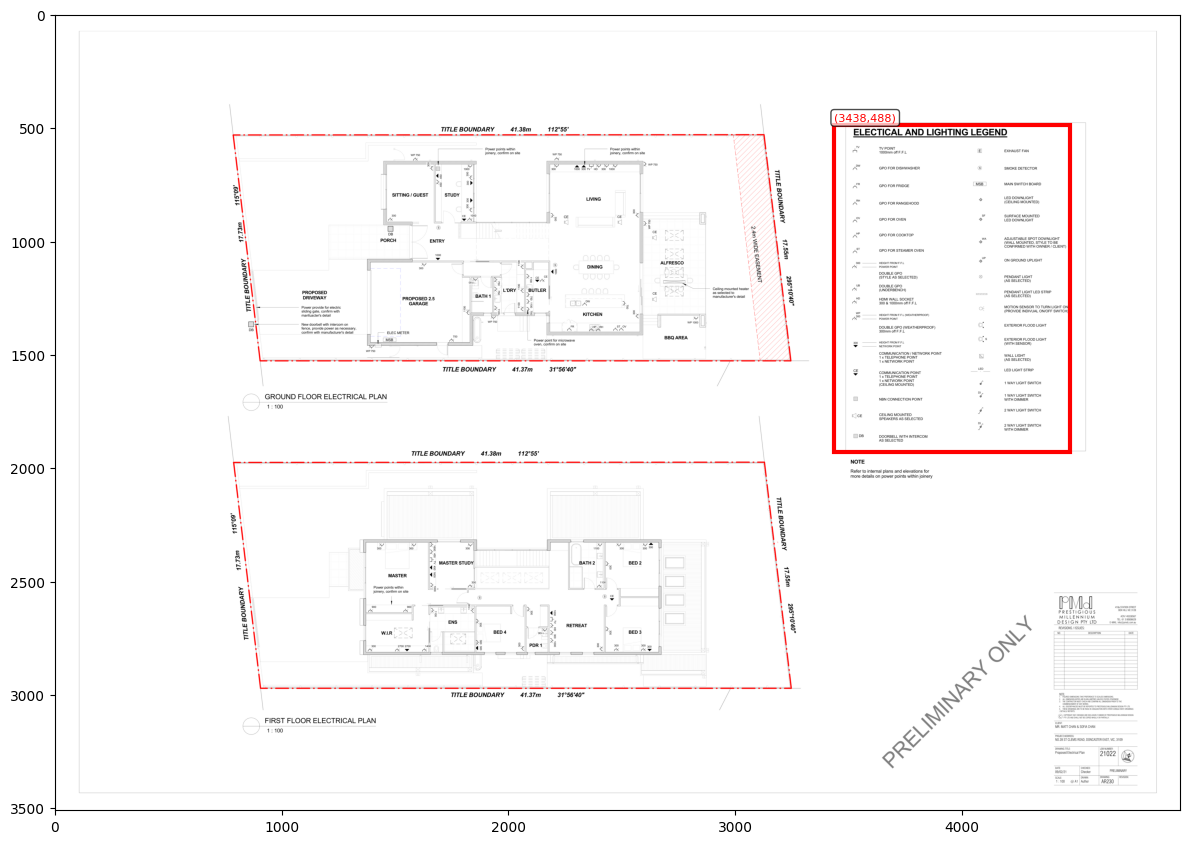

In [76]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(12, 12))

# Use the SAME scale factor from your pixmap rendering
# scale = 4.1  # This is dpi / 72.0 = 144 / 72.0
print(f"scale: {scale}")

# Display image - origin='upper' puts (0,0) at top-left to match LLM
ax.imshow(img, origin="upper")

boxes = response.bounding_boxes
if boxes:
    for box in boxes:
        # Scale coordinates from PDF points to pixel coordinates
        x0_px = box.x0 * scale
        y0_px = box.y0 * scale
        x1_px = box.x1 * scale
        y1_px = box.y1 * scale

        ax.add_patch(
            patches.Rectangle(
                (x0_px, y0_px),
                x1_px - x0_px,
                y1_px - y0_px,
                linewidth=3,
                edgecolor="red",
                facecolor="none",
            )
        )
        # Add label to verify
        ax.text(
            x0_px,
            y0_px - 20,
            f"({x0_px:.0f},{y0_px:.0f})",
            color="red",
            fontsize=8,
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
        )

# ax.axis("off")
plt.tight_layout()
plt.show()

# original PDF -> exported PDF
# MediaBox: Rect(0.0, 0.0, 1684.0, 2384.0) -> Rect(0.0, 0.0, 1191.0, 842.0)
# PDF (pix) dimensions: 4963x3509 pixels -> 4963x3509 pixels
# len(png_bytes): 897456 -> 870703
# LLM ori bbox: BoundingBox(x0=835.0, y0=97.0, x1=1102.0, y1=463.0) -> BoundingBox(x0=825.0, y0=117.0, x1=1075.0, y1=463.0)
# LLM scaled bbox: (1738,202) -> (3438,488)
# scale: 2.0817953020134228 -> scale: 4.166666666666667

In [20]:
# choose DPI (e.g., 144 dpi). 72 dpi is 1:1 with PDF points
dpi = 300
legend_scale = dpi / 72.0
matrix = pymupdf.Matrix(legend_scale, legend_scale)

pix_high_res = doc[0].get_pixmap(matrix=matrix)
width_px, height_px = pix_high_res.width, pix_high_res.height
print(f"PDF page dimensions: {width_px}x{height_px} pixels")

# Get raw pixel buffer (not PNG)
buf = pix_high_res.samples  # or: pix.samples_memoryview() in newer PyMuPDF

# Determine channels
channels = (pix_high_res.n + 1) if pix_high_res.alpha else pix_high_res.n  # e.g., RGB=3, RGBA=4, Gray=1

# Build array
img_high_res = np.frombuffer(buf, dtype=np.uint8).reshape(pix_high_res.height, pix_high_res.width, channels)

PDF page dimensions: 4963x3509 pixels


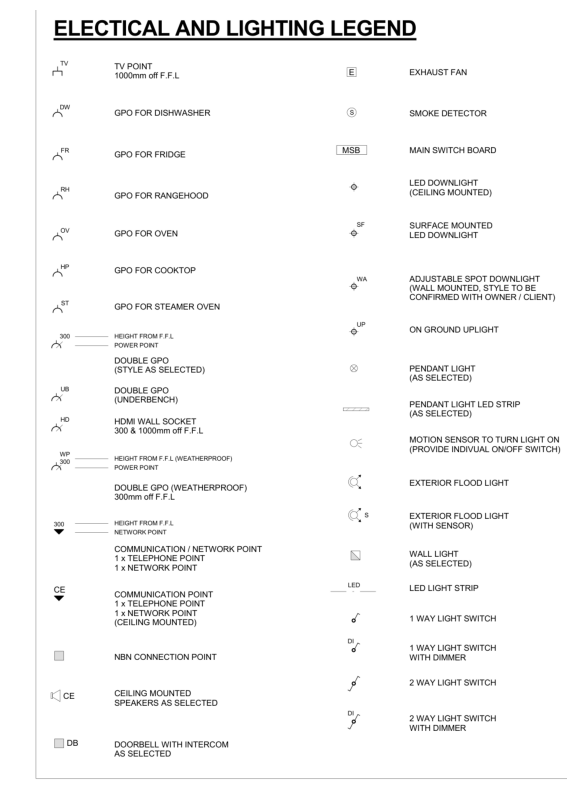

In [29]:
# crop bounding box region out of original image
boxes = response.bounding_boxes
if boxes:
    for box in boxes:
        # Scale coordinates from PDF points to pixel coordinates
        x0_px = box.x0 * scale
        y0_px = box.y0 * scale
        x1_px = box.x1 * scale
        y1_px = box.y1 * scale

        # Crop the region
        cropped_img = img[int(y0_px):int(y1_px), int(x0_px):int(x1_px)]

        # Display the cropped region
        plt.figure(figsize=(10, 10))
        plt.imshow(cropped_img, cmap=None if cropped_img.ndim == 3 and cropped_img.shape[2] != 1 else "gray")
        plt.axis("off")
        plt.show()


In [30]:
# save cropped_img as png
plt.imsave("cropped_img.png", cropped_img)

In [ ]:
cropped_img_base64 = numpy_to_base64_png(cropped_img)

In [20]:
cropped_img.shape

(145, 128, 3)

In [41]:
# use cropped image from before
cropped_image = cropped_images[0]
# Convert to PNG bytes
buffer = BytesIO()
cropped_image.save(buffer, format="PNG")
png_bytes = buffer.getvalue()

cropped_img_base64 = base64.b64encode(png_bytes).decode("utf-8")

In [42]:
# legend_llm = init_chat_model("openai:gpt-4.1")
# legend_llm = init_chat_model("google_genai:gemini-2.5-pro")
legend_llm = init_chat_model(
    # "qwen2.5-vl-72b-instruct",
    "qwen3-vl-235b-a22b-instruct",
    # "qwen3-vl-plus",
    model_provider="openai",
    base_url="https://dashscope-intl.aliyuncs.com/compatible-mode/v1",
    api_key=os.getenv("DASHSCOPE_API_KEY"),
)

class LegendItem(BaseModel):
    symbol_bounding_box: BoundingBox = Field(description="Bounding box coordinates of the legend symbol")
    meaning: str = Field(description="Meaning or description of the legend item, as-is")


class LegendAnalysis(BaseModel):
    legend_items: List[LegendItem] = Field(description="Legend items in the legend box")

legend_message = {
    "role": "user",
    "content": [
        {
            "type": "text",
            # "text": "Describe and classify the category of the document. Also perform detection of the legend box in the document and provide coordinates of bounding box, if it exists. A legend box usually contains a list of symbols and their meanings.",
            # "text": "Locate every symbol in the legend box and output their bbox coordinates and accompanying description.",
            "text": "Locate every symbol in the legend box and output their bbox coordinates and accompanying description. Assume the origin to be on the top left. Return in JSON format",
        },
        # {
        #     "type": "image",
        #     "source_type": "base64",
        #     "data": cropped_img_base64,
        #     "mime_type": "image/png",
        # },
        {  # for qwen3-vl-235b-a22b-instruct
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{cropped_img_base64}"},
            # "min_pixels": min_pixels,
            # "max_pixels": max_pixels,
        },
    ],
}
legend_sllm = legend_llm.with_structured_output(LegendAnalysis)
legend_response = legend_llm.invoke([legend_message])
print(legend_response)

content='{\n  "symbols": [\n    {\n      "bbox_2d": [18, 67, 54, 92],\n      "description": "TO POINT 100mm off F.F.L."\n    },\n    {\n      "bbox_2d": [18, 113, 54, 138],\n      "description": "GPO FOR DISHWASHER"\n    },\n    {\n      "bbox_2d": [18, 158, 54, 183],\n      "description": "GPO FOR FRIDGE"\n    },\n    {\n      "bbox_2d": [18, 203, 54, 228],\n      "description": "GPO FOR RANGEHOOD"\n    },\n    {\n      "bbox_2d": [18, 248, 54, 273],\n      "description": "GPO FOR OVEN"\n    },\n    {\n      "bbox_2d": [18, 293, 54, 318],\n      "description": "GPO FOR COOKTOP"\n    },\n    {\n      "bbox_2d": [18, 338, 54, 363],\n      "description": "GPO FOR STEAMER/OVEN"\n    },\n    {\n      "bbox_2d": [18, 383, 54, 408],\n      "description": "DOUBLE GPO (STYLUS AS SELECTED)"\n    },\n    {\n      "bbox_2d": [18, 428, 54, 453],\n      "description": "DOUBLE GPO (UNDERBENCH)"\n    },\n    {\n      "bbox_2d": [18, 473, 54, 498],\n      "description": "KERNEL RAIL SOCKET 300 & 100mm

In [45]:
print(legend_response.content)

{
  "symbols": [
    {
      "bbox_2d": [18, 67, 54, 92],
      "description": "TO POINT 100mm off F.F.L."
    },
    {
      "bbox_2d": [18, 113, 54, 138],
      "description": "GPO FOR DISHWASHER"
    },
    {
      "bbox_2d": [18, 158, 54, 183],
      "description": "GPO FOR FRIDGE"
    },
    {
      "bbox_2d": [18, 203, 54, 228],
      "description": "GPO FOR RANGEHOOD"
    },
    {
      "bbox_2d": [18, 248, 54, 273],
      "description": "GPO FOR OVEN"
    },
    {
      "bbox_2d": [18, 293, 54, 318],
      "description": "GPO FOR COOKTOP"
    },
    {
      "bbox_2d": [18, 338, 54, 363],
      "description": "GPO FOR STEAMER/OVEN"
    },
    {
      "bbox_2d": [18, 383, 54, 408],
      "description": "DOUBLE GPO (STYLUS AS SELECTED)"
    },
    {
      "bbox_2d": [18, 428, 54, 453],
      "description": "DOUBLE GPO (UNDERBENCH)"
    },
    {
      "bbox_2d": [18, 473, 54, 498],
      "description": "KERNEL RAIL SOCKET 300 & 100mm off F.F.L."
    },
    {
      "bbox_2d": [18, 5

Resized image size: 279x387


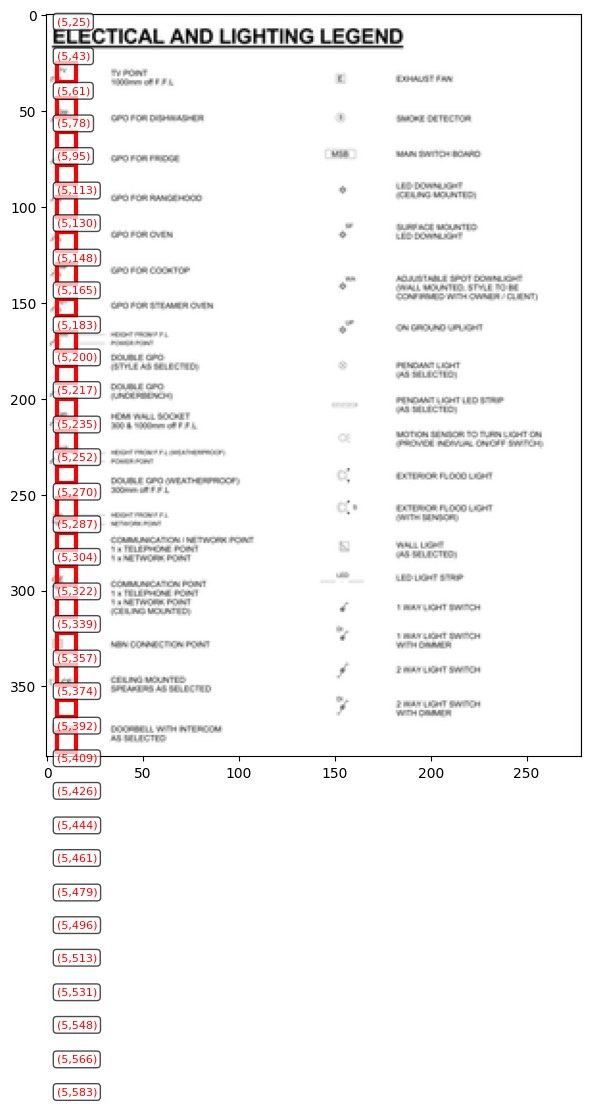

In [ ]:
# plot bboxes qwen cookbook way
cropped_image_plot = Image.open(BytesIO(png_bytes))

cropped_image_plot.thumbnail([1280, 1280], Image.Resampling.LANCZOS)
width, height = cropped_image_plot.size
print(f"Resized image size: {width}x{height}")

bounding_boxes = legend_response.content
try:
    json_output = ast.literal_eval(bounding_boxes)["symbols"]
except Exception as e:
    end_idx = bounding_boxes.rfind('"}') + len('"}')
    truncated_text = bounding_boxes[:end_idx] + "]"
    json_output = ast.literal_eval(truncated_text)

if not isinstance(json_output, list):
    json_output = [json_output]

fig, ax = plt.subplots(figsize=(12, 12))

# Iterate over the bounding boxes
for i, bounding_box in enumerate(json_output):
    # Convert normalized coordinates to absolute coordinates
    abs_y1 = int(bounding_box["bbox_2d"][1] / 1000 * height)
    abs_x1 = int(bounding_box["bbox_2d"][0] / 1000 * width)
    abs_y2 = int(bounding_box["bbox_2d"][3] / 1000 * height)
    abs_x2 = int(bounding_box["bbox_2d"][2] / 1000 * width)

    if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

    if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

    ax.add_patch(
        patches.Rectangle(
            (abs_x1, abs_y1),
            abs_x2 - abs_x1,
            abs_y2 - abs_y1,
            linewidth=3,
            edgecolor="red",
            facecolor="none",
        )
    )

    ax.text(
        abs_x1,
        abs_y1 - 20,
        f"({abs_x1:.0f},{abs_y1:.0f})",
        color="red",
        fontsize=8,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
    )

ax.imshow(cropped_image_plot, origin="upper")
plt.tight_layout()
plt.show()

In [93]:
# for qwen3-vl-plus which doesn't support structured output
# covnert json string to dict
import json
response_json = json.loads(legend_response.content)
response_json
# display detected legend items
legend_boxes = []
for box in response_json["symbols"]:
    # in this format: "symbol_bbox": [108, 136, 327, 158],
    bbox = BoundingBox(
        x0=box["bbox_2d"][0],
        y0=box["bbox_2d"][1],
        x1=box["bbox_2d"][2],
        y1=box["bbox_2d"][3],
    )
    legend_item = LegendItem(
        symbol_bounding_box=bbox,
        meaning=box["description"],
    )
    legend_boxes.append(legend_item)

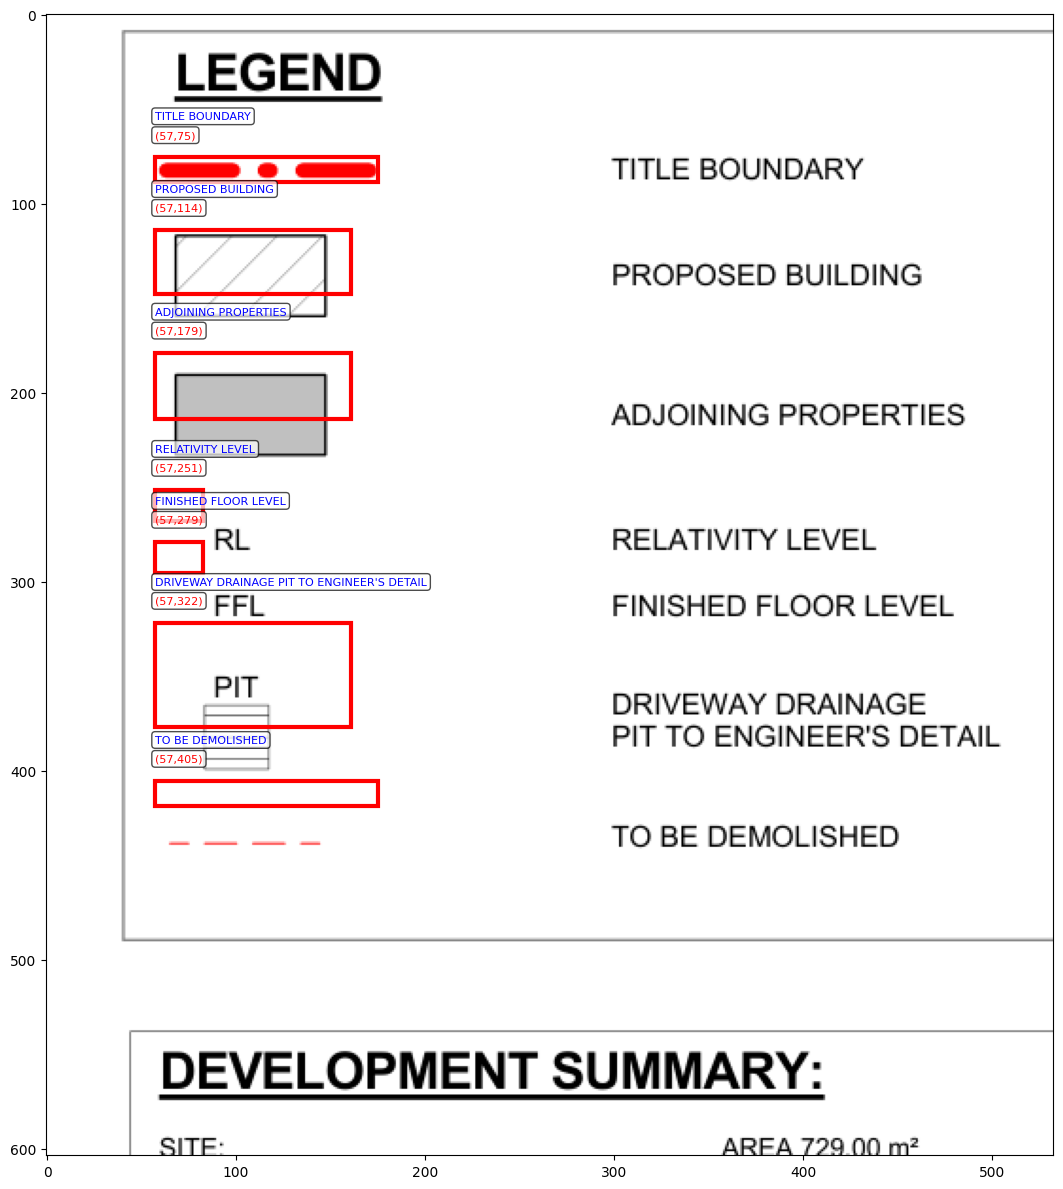

In [96]:
# display detected legend items
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(cropped_img, origin="upper")

legend_scale_new = 0.55
x_offset = 0
y_offset = 0

# calculating scale
# legend_boxes = legend_response.legend_items
if legend_boxes:
    for box in legend_boxes:
        # Scale coordinates from PDF points to pixel coordinates
        x0_px = (box.symbol_bounding_box.x0 * legend_scale_new) - x_offset
        y0_px = (box.symbol_bounding_box.y0 * legend_scale_new) - y_offset
        x1_px = (box.symbol_bounding_box.x1 * legend_scale_new) - x_offset
        y1_px = (box.symbol_bounding_box.y1 * legend_scale_new) - y_offset

        ax.add_patch(
            patches.Rectangle(
                (x0_px, y0_px),
                x1_px - x0_px,
                y1_px - y0_px,
                linewidth=3,
                edgecolor="red",
                facecolor="none",
            )
        )
        # Add label to verify
        ax.text(
            x0_px,
            y0_px - 10,
            f"({x0_px:.0f},{y0_px:.0f})",
            color="red",
            fontsize=8,
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
        )
        # Add text label
        ax.text(
            x0_px,
            y0_px - 20,
            box.meaning,
            color="blue",
            fontsize=8,
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
        )

plt.tight_layout()
plt.show()

### First pass: pipeline

- Enter page number and PDF path
- Read PDF and show page
- Perform legend box detection and show bbox
- Crop bbox and show
- Save as PDF file + page num png

==== READ PDF ====
CropBox: Rect(0.0, 0.0, 841.8900146484375, 595.2760009765625)
Rotation: 0
PDF page dimensions: 841.8900146484375 x 595.2760009765625 points
Page in inches: 11.692916870117188 x 8.267722235785591 inches
Most likely paper size: A1 (allowing 5% tolerance)
PDF dimensions: 3508x2481 pixels
Resized image size: 3508x2481


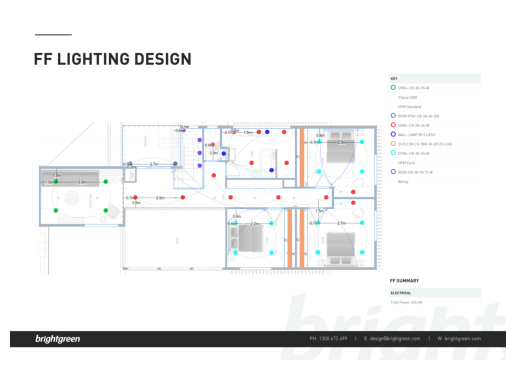

==== EXTRACT LEGEND BOX ====
content='{\n  "legend_boxes": [\n    {\n      "bbox_2d": [764, 185, 949, 507],\n      "description": "Legend box containing symbols and their meanings for lighting fixtures and wiring."\n    }\n  ]\n}' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 60, 'prompt_tokens': 2592, 'total_tokens': 2652, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': None, 'rejected_prediction_tokens': None, 'text_tokens': 60}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': None, 'image_tokens': 2522, 'text_tokens': 70}}, 'model_name': 'qwen3-vl-235b-a22b-instruct', 'system_fingerprint': None, 'id': 'chatcmpl-6f1c944d-c8ad-92e0-81f0-062a7dc594a5', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None} id='run--111b71ea-2a0c-47c8-b978-3113c3f94b42-0' usage_metadata={'input_tokens': 2592, 'output_tokens': 60, 'total_tokens': 2652, 'input_token_details'

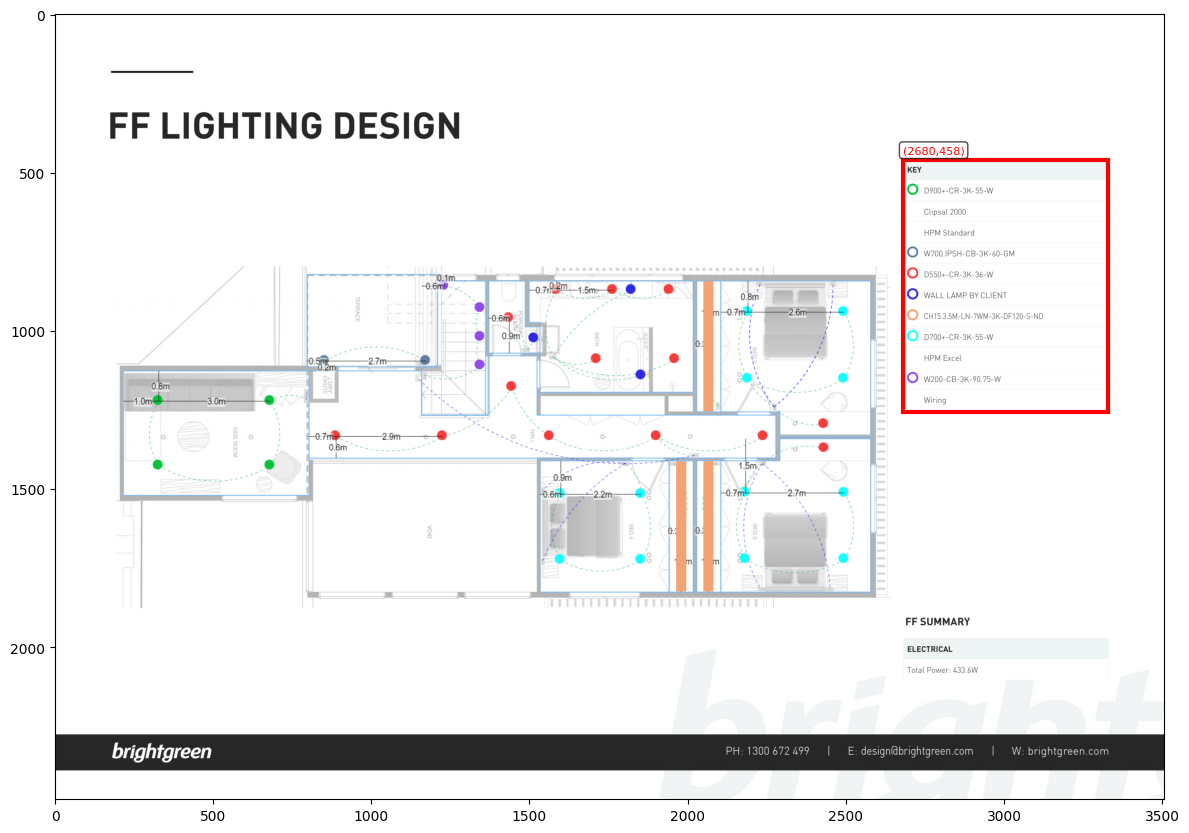

Saving cropped image to train/export_round1_1/Brightgreen Lighting Layout_3_0.png


In [32]:
EXPORT_DIR = Path("train/export_round1_1")

# plans_pdf = "/Users/shenghan/Code/scopeiq-ai-backend/files/28 St Clems Rd Doncaster East - Working Drawings.pdf"
# plans_pdf = "/Users/shenghan/Code/scopeiq-ai-backend/files/Fw_ 17 Cappella St Balwyn North/17 Cappella St Balwyn North - Working drawings.pdf"
# plans_pdf = "/Users/shenghan/Code/scopeiq-ai-backend/files/Fw_ 17 Cappella St Balwyn North/17 Cappella St Balwyn North - Endorsed Plans.pdf"
# plans_pdf = "/Users/shenghan/Code/scopeiq-ai-backend/files/2018950 FINAL ELECTRICAL DATA WD A1 of 1  -  141 Charles Street NORTHCOTE VIC 3070 Final Scope (21032020).pdf"
# plans_pdf = "/Users/shenghan/Code/scopeiq-ai-backend/files/141 Charles Street_Planting Plan REV B.pdf"
# plans_pdf = "/Users/shenghan/Code/scopeiq-ai-backend/files/Unorganised/60492284-DRG-EL-5001-T4.pdf"
# plans_pdf = "/Users/shenghan/Code/scopeiq-ai-backend/files/Unorganised/60492284-DRG-HY-1307-T2.pdf"
# plans_pdf = "/Users/shenghan/Code/scopeiq-ai-backend/files/Unorganised/Architectural Drawings 020520.pdf"
plans_pdf = "/Users/shenghan/Code/scopeiq-ai-backend/files/Unorganised/Brightgreen Lighting Layout.pdf"
# plans_pdf = "/Users/shenghan/Code/scopeiq-ai-backend/files/Unorganised/Full Structural Drawings Set.pdf"
# plans_pdf = "/Users/shenghan/Code/scopeiq-ai-backend/files/141 Charles St/2018950 CURRENT ECP1of2 REV A WITH ENERGY STAMP - 141 CHARLES ST NORTHCOTE VIC 3070.pdf"
# plans_pdf = (
#     "/Users/shenghan/Code/scopeiq-ai-backend/files/Brightgreen Lighting Layout.pdf"
# )
page_num = 3

doc = pymupdf.open(plans_pdf)
page = doc[page_num - 1]
# pdf_bytes = page.tobytes()

# check paper size
print("==== READ PDF ====")
print(f"CropBox: {page.cropbox}")
print(f"Rotation: {page.rotation}")  # 90: landscape
# Get dimensions accounting for rotation
if page.rotation in [90, 270]:
    page_width = page.mediabox.height
    page_height = page.mediabox.width
else:
    page_width = page.mediabox.width
    page_height = page.mediabox.height

print(f"PDF page dimensions: {page_width} x {page_height} points")

# convert points to pixels
paper_sizes = {
    "A1": {"mm": (594, 841), "inches": (23.4, 33.1)},
    "A2": {"mm": (420, 594), "inches": (16.5, 23.4)},
    "A3": {"mm": (297, 420), "inches": (11.7, 16.5)},
    "A4": {"mm": (210, 297), "inches": (8.3, 11.7)},
}
width_inches = page_width / 72.0
height_inches = page_height / 72.0
print(f"Page in inches: {width_inches} x {height_inches} inches")
# find most likely paper size
# Allow some tolerance (5% bigger) for matching slightly larger paper sizes
tolerance = 1.05
found_size = None
for size, dims in paper_sizes.items():
    max_width = dims["inches"][0] * tolerance
    max_height = dims["inches"][1] * tolerance
    if width_inches <= max_width and height_inches <= max_height:
        print(f"Most likely paper size: {size} (allowing 5% tolerance)")
        found_size = size
        break
if found_size is None:
    print("Paper size does not closely match standard sizes (even with tolerance)")


################################
# OPTION 1: CONVERT TO PNG AND EXPORT AT 300 DPI
# choose DPI (e.g., 144 dpi). 72 dpi is 1:1 with PDF points
# can be 150, 300, 600
dpi = 300  # 300
scale = dpi / 72.0
matrix = pymupdf.Matrix(scale, scale)

pix = page.get_pixmap(matrix=matrix)
width_px, height_px = pix.width, pix.height
print(f"PDF dimensions: {width_px}x{height_px} pixels")

png_bytes = pix.tobytes("png")

################################
# OPTION 2: convert whatever to 4963x3509 target resolution
# Target pixel dimensions
TARGET_WIDTH = 4963
TARGET_HEIGHT = 3509 # Maintains ~1.41 aspect ratio (A-series)

# Calculate scaling to fit target while maintaining aspect ratio
# scale_x = TARGET_WIDTH / page_width
# scale_y = TARGET_HEIGHT / page_height

# print(f"Scale factors: x={scale_x:.4f}, y={scale_y:.4f}")

# # Maintain aspect ratio (fit within target)
# scale = min(scale_x, scale_y)
# matrix = pymupdf.Matrix(scale, scale)

# pix = page.get_pixmap(matrix=matrix)
# print(f"Pixmap dimensions: {pix.width} x {pix.height} pixels")

# png_bytes = pix.tobytes("png")

################################
# Display PDF page
# Get raw pixel buffer (not PNG)
# buf = pix.samples  # or: pix.samples_memoryview() in newer PyMuPDF

# # Determine channels
# channels = (pix.n + 1) if pix.alpha else pix.n  # e.g., RGB=3, RGBA=4, Gray=1

# # Build array
# img = np.frombuffer(buf, dtype=np.uint8).reshape(pix.height, pix.width, channels)

# # Optionally drop alpha if present
# if channels == 4:
#     img = img[:, :, :3]

# plt.imshow(img, cmap=None if img.ndim == 3 and img.shape[2] != 1 else "gray")
# plt.axis("off")
# plt.show()
# print("img dimensions: ", img.shape)

################################
# Display PDF page - Qwen style
image = Image.open(BytesIO(png_bytes))

# Skip resizing - need original resolution for cropping and training
# image.thumbnail([1280, 1280], Image.Resampling.LANCZOS)
width, height = image.size
print(f"Resized image size: {width}x{height}")
# show image
plt.imshow(image)
plt.axis("off")
plt.show()

################################
# EXTRACT LEGEND BOX
print("==== EXTRACT LEGEND BOX ====")
# llm = init_chat_model("openai:gpt-4.1")
# llm = init_chat_model("google_genai:gemini-2.5-flash")
llm = init_chat_model(
    # "qwen2.5-vl-72b-instruct",
    "qwen3-vl-235b-a22b-instruct",
    model_provider="openai",
    base_url="https://dashscope-intl.aliyuncs.com/compatible-mode/v1",
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    # extra_body={"vl_high_resolution_images": True},
)


class BoundingBox(BaseModel):
    x0: float = Field(
        description="The x coordinate of the top left corner of the bounding box"
    )
    y0: float = Field(
        description="The y coordinate of the top left corner of the bounding box"
    )
    x1: float = Field(
        description="The x coordinate of the bottom right corner of the bounding box"
    )
    y1: float = Field(
        description="The y coordinate of the bottom right corner of the bounding box"
    )


class DocumentAnalysis(BaseModel):
    legend_box: str = Field(
        description="Summarise what is in the legend box if it exists"
    )
    bounding_boxes: List[BoundingBox] = Field(
        description="Detected bounding boxes of the legend box if it exists. Assume origin on the top left."
    )


message = {
    "role": "user",
    "content": [
        {
            "type": "text",
            # "text": "Describe and classify the category of the document. Also perform detection of the legend box in the document and provide coordinates of bounding box, if it exists. A legend box usually contains a list of symbols and their meanings.",
            # "text": "Perform detection of legend boxes in the document and provide coordinates of bounding box, if it exists. A legend box usually contains a list of symbols and their meanings. There may be multiple legend boxes in one drawing",
            "text": "Perform detection of legend boxes in the document and provide coordinates of bounding box, if it exists. A legend box usually contains a list of symbols and their meanings. There may be multiple legend boxes in one drawing. These boxes sometimes may overlap. Be sure to include all symbols. Report bbox coordinates in JSON format.",
        },
        # {
        #     "type": "file",
        #     "source_type": "base64",
        #     "data": base64.b64encode(pdf_bytes).decode("utf-8"),
        #     "mime_type": "application/pdf",
        #     "filename": "my-file",
        # },
        {
            "type": "image",
            "source_type": "base64",
            "data": base64.b64encode(png_bytes).decode("utf-8"),
            "mime_type": "image/png",
        },
    ],
}
# sllm = llm.with_structured_output(DocumentAnalysis)
response = llm.invoke([message])
print(response)

################################
# PRINT BBOXES - QWEN3 STYLE
bounding_boxes = parse_json(response.content)
try:
    json_output = ast.literal_eval(bounding_boxes)["legend_boxes"]
except Exception as e:
    end_idx = bounding_boxes.rfind('"}') + len('"}')
    truncated_text = bounding_boxes[:end_idx] + "]"
    json_output = ast.literal_eval(truncated_text)

if not isinstance(json_output, list):
    json_output = [json_output]

cropped_images = []

fig, ax = plt.subplots(figsize=(12, 12))

# Iterate over the bounding boxes
abs_bounding_boxes = []
for i, bounding_box in enumerate(json_output):
    # Convert normalized coordinates to absolute coordinates
    abs_y1 = int(bounding_box["bbox_2d"][1] / 1000 * height)
    abs_x1 = int(bounding_box["bbox_2d"][0] / 1000 * width)
    abs_y2 = int(bounding_box["bbox_2d"][3] / 1000 * height)
    abs_x2 = int(bounding_box["bbox_2d"][2] / 1000 * width)

    if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

    if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

    abs_bounding_boxes.append((abs_x1, abs_y1, abs_x2, abs_y2))

    # Crop the bounding box region
    cropped_image = image.crop((abs_x1, abs_y1, abs_x2, abs_y2))
    cropped_images.append(cropped_image)
    ax.add_patch(
        patches.Rectangle(
            (abs_x1, abs_y1),
            abs_x2 - abs_x1,
            abs_y2 - abs_y1,
            linewidth=3,
            edgecolor="red",
            facecolor="none",
        )
    )

    ax.text(
        abs_x1,
        abs_y1 - 20,
        f"({abs_x1:.0f},{abs_y1:.0f})",
        color="red",
        fontsize=8,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
    )

ax.imshow(image, origin="upper")
plt.tight_layout()
plt.show()

################################
# PRINT BBOXES
# fig, ax = plt.subplots(figsize=(12, 12))

# # Use the SAME scale factor from your pixmap rendering
# scale = 300/72  # This is dpi / 72.0 = 144 / 72.0

# # Display image - origin='upper' puts (0,0) at top-left to match LLM
# ax.imshow(img, origin="upper")

# boxes = response.bounding_boxes
# if boxes:
#     for box in boxes:
#         # Scale coordinates from PDF points to pixel coordinates
#         x0_px = box.x0 * scale
#         y0_px = box.y0 * scale
#         x1_px = box.x1 * scale
#         y1_px = box.y1 * scale

#         ax.add_patch(
#             patches.Rectangle(
#                 (x0_px, y0_px),
#                 x1_px - x0_px,
#                 y1_px - y0_px,
#                 linewidth=3,
#                 edgecolor="red",
#                 facecolor="none",
#             )
#         )
#         # Add label to verify
#         ax.text(
#             x0_px,
#             y0_px - 20,
#             f"({x0_px:.0f},{y0_px:.0f})",
#             color="red",
#             fontsize=8,
#             bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
#         )

# # ax.axis("off")
# plt.tight_layout()
# plt.show()

###############################
# CROP BOUNDING BOX
# crop bounding box region out of original image
box_count = 0
for cropped_image in cropped_images:
    # save as cropped_img as PNG
    pdf_filename = Path(plans_pdf).stem
    png_filename = f"{pdf_filename}_{page_num}_{box_count}.png"
    save_path = EXPORT_DIR / png_filename
    print(f"Saving cropped image to {save_path}")
    plt.imsave(save_path, cropped_image, cmap="gray")
    box_count += 1

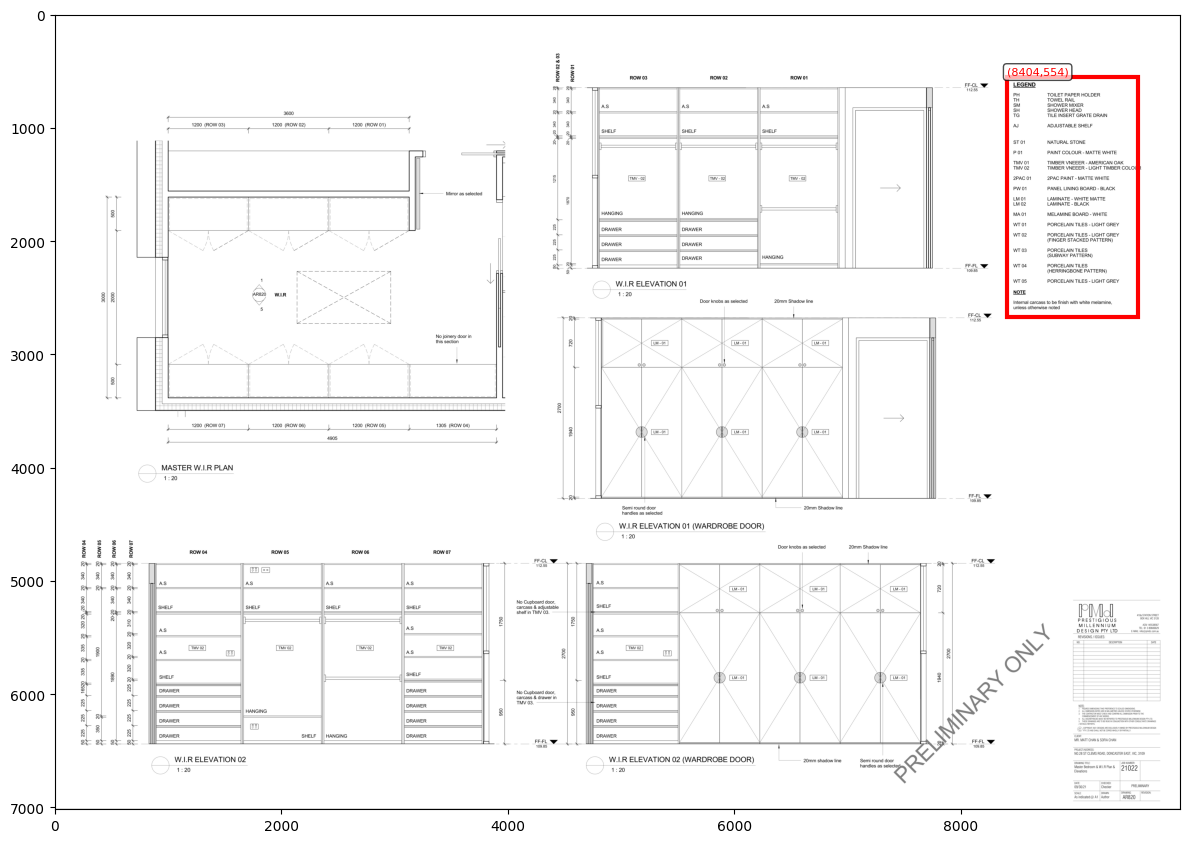

Saving cropped image to train/export_round1_1/28 St Clems Rd Doncaster East - Working Drawings_37_0.png


In [27]:
################################
# CROP BOUNDING BOX - MANUAL ADJUSTMENT
# crop bounding box region out of original image

fig, ax = plt.subplots(figsize=(12, 12))

# Iterate over the bounding boxes
abs_bounding_boxes = []
cropped_images = []
for i, bounding_box in enumerate(json_output):
    # Convert normalized coordinates to absolute coordinates
    abs_y1 = int(bounding_box["bbox_2d"][1] / 1000 * height)
    abs_x1 = int(bounding_box["bbox_2d"][0] / 1000 * width) 
    abs_y2 = int(bounding_box["bbox_2d"][3] / 1000 * height) 
    abs_x2 = int(bounding_box["bbox_2d"][2] / 1000 * width) + 100

    if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1

    if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

    abs_bounding_boxes.append((abs_x1, abs_y1, abs_x2, abs_y2))

    # Crop the bounding box region
    cropped_image = image.crop((abs_x1, abs_y1, abs_x2, abs_y2))
    cropped_images.append(cropped_image)
    ax.add_patch(
        patches.Rectangle(
            (abs_x1, abs_y1),
            abs_x2 - abs_x1,
            abs_y2 - abs_y1,
            linewidth=3,
            edgecolor="red",
            facecolor="none",
        )
    )

    ax.text(
        abs_x1,
        abs_y1 - 20,
        f"({abs_x1:.0f},{abs_y1:.0f})",
        color="red",
        fontsize=8,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.7),
    )

ax.imshow(image, origin="upper")
plt.tight_layout()
plt.show()

box_count = 0
for cropped_image in cropped_images:
    # save as cropped_img as PNG
    pdf_filename = Path(plans_pdf).stem
    png_filename = f"{pdf_filename}_{page_num}_{box_count}.png"
    save_path = EXPORT_DIR / png_filename
    print(f"Saving cropped image to {save_path}")
    plt.imsave(save_path, cropped_image, cmap="gray")
    box_count += 1

## Stage 3: Template matching

In [301]:
from PIL import Image
import cv2 as cv

In [302]:
# symbol_ce_img = Image.open("files/symbol.png")
symbol_img = Image.open(
    "/Users/shenghan/Code/scopeiq-ai-backend/train/results/round-4-processed/cropped/28 St Clems Rd Doncaster East - Working Drawings_3_0_0_1_symbol.png"
)

PDF page dimensions: 9934x7017 pixels


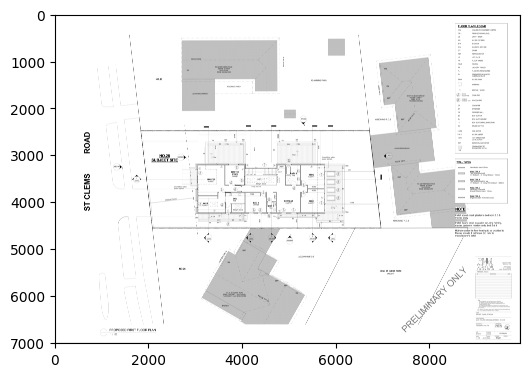

In [303]:
# read full drawing from PDF
plans_pdf = "/Users/shenghan/Code/scopeiq-ai-backend/files/28 St Clems Rd Doncaster East - Working Drawings.pdf"
page_num = 3
doc = pymupdf.open(plans_pdf)
page = doc[page_num]

# choose DPI (e.g., 144 dpi). 72 dpi is 1:1 with PDF points
dpi = 300
scale = dpi / 72.0
matrix = pymupdf.Matrix(scale, scale)

pix = page.get_pixmap(matrix=matrix)
width_px, height_px = pix.width, pix.height
print(f"PDF page dimensions: {width_px}x{height_px} pixels")

# Convert pixmap to MatLike object (OpenCV-compatible numpy array)
buf = pix.samples
channels = (pix.n + 1) if pix.alpha else pix.n

# Build numpy array
img = np.frombuffer(buf, dtype=np.uint8).reshape(pix.height, pix.width, channels)

# Drop alpha channel if present
if channels == 4:
    img = img[:, :, :3]

# Convert RGB to GRAY
if img.ndim == 3 and img.shape[2] == 3:
    img_train = cv.cvtColor(img, cv.COLOR_RGBA2GRAY)

fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(img_train, cmap="gray")
plt.show()

Not enough matches are found - 6/10
Found 6/33 good matches


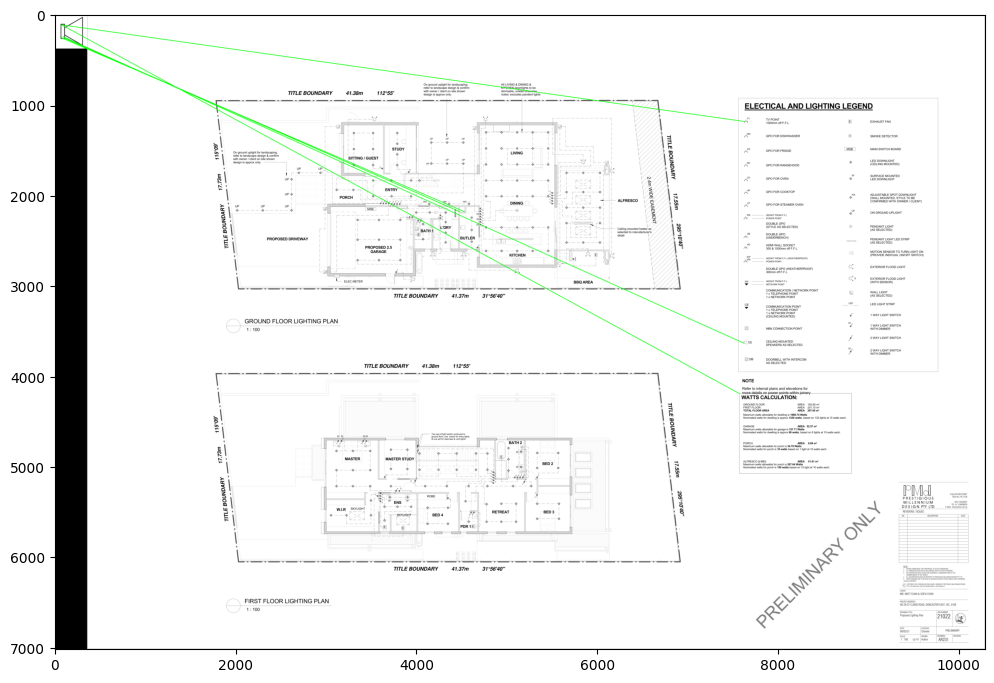

(<matplotlib.image.AxesImage at 0x31ff91190>, None)

In [13]:
img_query = cv.imread("files/symbol.png", cv.IMREAD_GRAYSCALE)  # queryImage

###### ORB
# The inherent simplicity and repetitive nature of symbols in a drawing mean that many
# of the detected corners might have locally similar appearances, potentially confusing
# the less distinctive rBRIEF descriptor and leading to ambiguous matches.

# Initiate ORB detector
# orb = cv.ORB_create()

# # find the keypoints and descriptors with ORB
# kp1, des1 = orb.detectAndCompute(img_query, None)
# kp2, des2 = orb.detectAndCompute(img_train, None)

# # create BFMatcher object
# bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# # Match descriptors.
# matches = bf.match(des1, des2)

# # Sort them in the order of their distance.
# matches = sorted(matches, key=lambda x: x.distance)

####### SIFT + FLANN
# more computationally expensive but more robust SIFT
# SIFT exhibits stronger resistance to low-texture conditions compared to algorithms like ORB
# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img_query, None)
kp2, des2 = sift.detectAndCompute(img_train, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)  # or pass empty dictionary

flann = cv.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1, des2, k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m, n in matches:
    if m.distance < 0.9 * n.distance:
        good.append(m)

MIN_MATCH_COUNT = 10
if len(good) > MIN_MATCH_COUNT:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    h, w = img_query.shape
    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    dst = cv.perspectiveTransform(pts, M)

    img_train = cv.polylines(img_train, [np.int32(dst)], True, 255, 3, cv.LINE_AA)

else:
    print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
    matchesMask = None

print(f"Found {len(good)}/{len(matches)} good matches")

draw_params = dict(
    matchColor=(0, 255, 0),  # draw matches in green color
    singlePointColor=None,
    matchesMask=matchesMask,  # draw only inliers
    matchesThickness=5,
    flags=2,
)

img3 = cv.drawMatches(img_query, kp1, img_train, kp2, good, None, **draw_params)

fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(img3, "gray"), plt.show()

In [88]:
methods = [
    "TM_CCOEFF",
    "TM_CCOEFF_NORMED",
    "TM_CCORR",
    "TM_CCORR_NORMED",
    "TM_SQDIFF",
    "TM_SQDIFF_NORMED",
]

Number of matches: 2


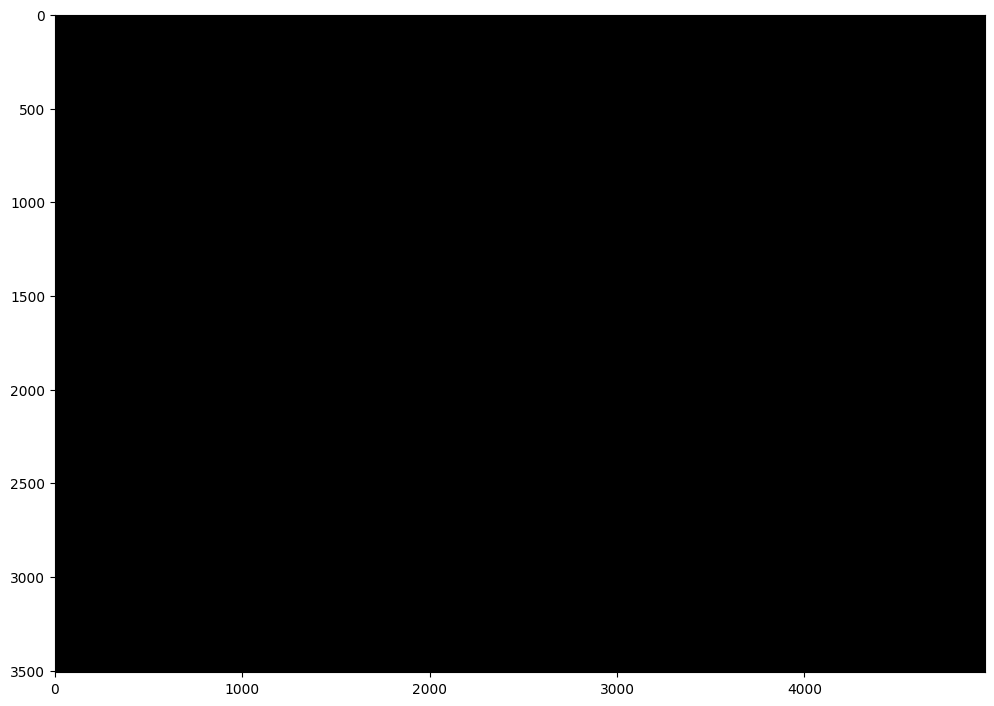

In [63]:
w, h = img_query.shape[::-1]

res = cv.matchTemplate(img_train, img_query, cv.TM_CCORR_NORMED)
threshold = 0.8
loc = np.where(res >= threshold)
print(f"Number of matches: {len(loc)}")
loc = loc[:10]
for pt in zip(*loc[::-1]):
    cv.rectangle(img_train, pt, (pt[0] + w, pt[1] + h), (0, 0, 255), 2)

fig, ax = plt.subplots(figsize=(12, 12))
plt.imshow(img_train, cmap="gray")
plt.show()

## Stage 3: Graph Matching

In [304]:
import numpy as np  # numpy backend
import cv2 as cv
import pygmtools as pygm
import matplotlib.pyplot as plt  # for plotting
from matplotlib.patches import ConnectionPatch  # for plotting matching result
import scipy.io as sio  # for loading .mat file
import scipy.spatial as spa  # for Delaunay triangulation
from sklearn.decomposition import PCA as PCAdimReduc
import itertools
from PIL import Image

pygm.set_backend("numpy")  # set numpy as backend for pygmtools

PDF page dimensions: 9934x7017 pixels


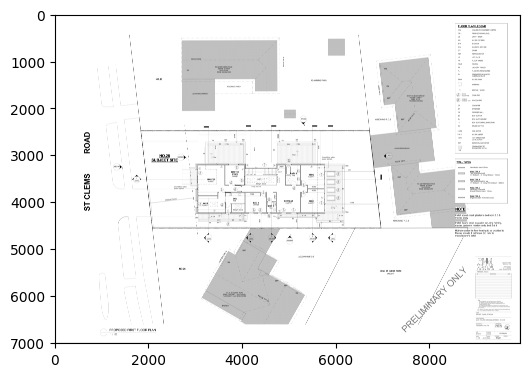

In [305]:
symbol_img = Image.open(
    "/Users/shenghan/Code/scopeiq-ai-backend/train/results/round-4-processed/cropped/28 St Clems Rd Doncaster East - Working Drawings_3_0_0_1_symbol.png"
)

# read full drawing from PDF
plans_pdf = "/Users/shenghan/Code/scopeiq-ai-backend/files/28 St Clems Rd Doncaster East - Working Drawings.pdf"
page_num = 3
doc = pymupdf.open(plans_pdf)
page = doc[page_num]

# choose DPI (e.g., 144 dpi). 72 dpi is 1:1 with PDF points
dpi = 300
scale = dpi / 72.0
matrix = pymupdf.Matrix(scale, scale)

pix = page.get_pixmap(matrix=matrix)
width_px, height_px = pix.width, pix.height
print(f"PDF page dimensions: {width_px}x{height_px} pixels")

# Convert pixmap to MatLike object (OpenCV-compatible numpy array)
buf = pix.samples
channels = (pix.n + 1) if pix.alpha else pix.n

# Build numpy array
img = np.frombuffer(buf, dtype=np.uint8).reshape(pix.height, pix.width, channels)

# Drop alpha channel if present
if channels == 4:
    img = img[:, :, :3]

# Convert RGB to GRAY
if img.ndim == 3 and img.shape[2] == 3:
    img_train = cv.cvtColor(img, cv.COLOR_RGBA2GRAY)

fig, ax = plt.subplots(figsize=(6, 6))
plt.imshow(img_train, cmap="gray")
plt.show()

## LLM-based query and search

All not good and hallucinated

Gemini 2.5 pro
```
Based on the engineering drawing provided, I have located the symbol for "CEILING MOUNTED SPEAKERS AS SELECTED".

There are a total of **8** occurrences of this symbol.

Here is a list of their locations:

**Ground Floor Electrical Plan (4 occurrences):**
1.  Living area
2.  Dining area
3.  Kitchen area
4.  Alfresco area

**First Floor Electrical Plan (4 occurrences):**
1.  Master/Study area
2.  Retreat area
3.  Bed 2
4.  Bed 3
```

GPT4.1
```
### **Summary of Occurrences**

**Total Occurrences: 9**

**Locations:**
#### Ground Floor Plan:
1. Living area (2 symbols)
2. Dining area (2 symbols)
3. Alfresco area (2 symbols)

#### First Floor Plan:
4. Retreat area (2 symbols)
5. Master Study (1 symbol)
```

qwen2.5-vl-72b-instruct
```
The symbol for "CEILING MOUNTED SPEAKERS AS SELECTED" appears 10 times in the provided engineering drawing. Here are the locations of each occurrence:

### Ground Floor Electrical Plan:
1. **Living Room**: Near the center of the room, close to the wall.
2. **Dining Area**: Above the dining table.
3. **Alfresco Area**: Close to the ceiling near the corner.

### First Floor Electrical Plan:
4. **Master Bedroom**: Near the bed area.
5. **Master Study**: Above the desk area.
6. **Bedroom 2**: Near the window.
7. **Bedroom 3**: Above the bed.
8. **Bedroom 4**: Near the corner of the room.
9. **Retreat**: Above the seating area.
10. **Bath 2**: Near the entrance of the bathroom.

Each of these locations is marked with the symbol that corresponds to the "CEILING MOUNTED SPEAKERS AS SELECTED" as shown in the legend on the right side of the drawing.
```

qwen3-vl-235b-a22b-instruct
```
### ✅ Final Count and Locations

**Total Occurrences: 5**

**List of All Occurrences:**

1. **Ground Floor — LIVING room** — Ceiling-mounted speaker (CE) near center of room.
2. **Ground Floor — DINING area** — CE symbol above dining table.
3. **Ground Floor — ALFRESCO area** — CE symbol over outdoor seating zone.
4. **First Floor — MASTER STUDY** — CE symbol near ceiling.
5. **First Floor — RETREAT** — CE symbol near ceiling.
```

In [99]:
img_query_base64 = numpy_to_base64_png(img_query)
img_train_base64 = numpy_to_base64_png(img_train)


/var/folders/lr/whd5k7vx6456g3_crvsy8hdm0000gn/T/ipykernel_62003/4154347301.py:39: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_img = Image.fromarray(img_array.astype("uint8"), mode="L")


In [113]:
# legend_llm = init_chat_model("openai:gpt-4.1")
# legend_llm = init_chat_model("google_genai:gemini-2.5-pro") # (22)
legend_llm = init_chat_model(
    # "qwen2.5-vl-72b-instruct", # not consistent results (4-6)
    "qwen3-vl-235b-a22b-instruct", # not consistent results (4-10)
    # "qwen3-vl-plus",
    model_provider="openai",
    base_url="https://dashscope-intl.aliyuncs.com/compatible-mode/v1",
    api_key=os.getenv("DASHSCOPE_API_KEY"),
)


# class LegendItem(BaseModel):
#     symbol_bounding_box: BoundingBox = Field(
#         description="Bounding box coordinates of the legend symbol"
#     )
#     meaning: str = Field(description="Meaning or description of the legend item, as-is")


# class LegendAnalysis(BaseModel):
#     legend_items: List[LegendItem] = Field(description="Legend items in the legend box")


symbol_count_message = {
    "role": "user",
    "content": [
        {
            "type": "text",
            # "text": "Describe and classify the category of the document. Also perform detection of the legend box in the document and provide coordinates of bounding box, if it exists. A legend box usually contains a list of symbols and their meanings.",
            # "text": "Locate every symbol in the legend box and output their bbox coordinates and accompanying description.",
            "text": """You're given a query image of a symbol and a training image of an engineering drawing. Your job is to locate the symbol and count how many times it appears in the drawing, then list out all occurrences.
The symbol description is: CEILING MOUNTED SPEAKERS AS SELECTED""",
        },
        # {
        #     "type": "image",
        #     "source_type": "base64",
        #     "data": img_query_base64,
        #     "mime_type": "image/png",
        # },
        # {
        #     "type": "image",
        #     "source_type": "base64",
        #     "data": img_train_base64,
        #     "mime_type": "image/png",
        # },
        
        {  # for qwen3-vl-235b-a22b-instruct
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{img_query_base64}"},
        },
        {  # for qwen3-vl-235b-a22b-instruct
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{img_train_base64}"},
        },
    ],
}
# legend_sllm = legend_llm.with_structured_output(LegendAnalysis)
symbol_count_response = legend_llm.invoke([symbol_count_message])
print(symbol_count_response.content)

Based on the provided engineering drawing and symbol query:

**Symbol Description:** CEILING MOUNTED SPEAKERS AS SELECTED  
**Query Symbol Image:** A speaker icon — a rectangle with a triangle pointing right, representing a loudspeaker.

---

### ✅ Step 1: Locate the Symbol in the Legend

In the **ELECTRICAL AND LIGHTING LEGEND** (top right of the drawing), we find:

> **CE** — CEILING MOUNTED SPEAKERS AS SELECTED

This confirms the symbol to look for is labeled “CE” in the plan.

---

### ✅ Step 2: Scan the Drawing for “CE” Symbols

We examine both the **GROUND FLOOR ELECTRICAL PLAN** and **FIRST FLOOR ELECTRICAL PLAN** for occurrences of “CE”.

#### 🔹 Ground Floor:
- In the **LIVING** room: One “CE” symbol near the center.
- In the **DINING** area: One “CE” symbol near the ceiling above the dining table.
- In the **ALFRESCO** area: One “CE” symbol near the ceiling over the outdoor seating.

→ **Total on Ground Floor: 3**

#### 🔹 First Floor:
- In the **MASTER STUDY**: One “CE” symbol

## Stage 2: Post-processing

- NMS and confidence filtering
- Row grouping
- Column detection

In [ ]:
import os
import json
import cv2
import torch
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from dataclasses import dataclass
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
from typing import List, Tuple, Dict, Any, Optional, Iterable
# from ultralytics import YOLO


def calculate_iou_json(box1: Dict[str, float], box2: Dict[str, float]) -> float:
    """
    Calculate Intersection over Union (IoU) between two bounding boxes in JSON format.

    Args:
        box1: {"x1": float, "y1": float, "x2": float, "y2": float}
        box2: {"x1": float, "y1": float, "x2": float, "y2": float}

    Returns:
        IoU value between 0 and 1
    """
    # Extract coordinates
    x1_1, y1_1, x2_1, y2_1 = box1["x1"], box1["y1"], box1["x2"], box1["y2"]
    x1_2, y1_2, x2_2, y2_2 = box2["x1"], box2["y1"], box2["x2"], box2["y2"]

    # Calculate intersection coordinates
    x1 = max(x1_1, x1_2)
    y1 = max(y1_1, y1_2)
    x2 = min(x2_1, x2_2)
    y2 = min(y2_1, y2_2)

    # Check if there's an intersection
    if x2 <= x1 or y2 <= y1:
        return 0.0

    # Calculate intersection area
    intersection = (x2 - x1) * (y2 - y1)

    # Calculate union area
    area1 = (x2_1 - x1_1) * (y2_1 - y1_1)
    area2 = (x2_2 - x1_2) * (y2_2 - y1_2)
    union = area1 + area2 - intersection

    return intersection / union if union > 0 else 0.0


def apply_nms_to_json_detections(
    detections: List[Dict[str, Any]],
    iou_threshold: float = 0.5,
    score_threshold: float = 0.2,
    class_agnostic: bool = False,
) -> List[Dict[str, Any]]:
    """
    Apply Non-Maximum Suppression to JSON detection results.

    Args:
        detections: List of detection dictionaries with keys: name, class, confidence, box
        iou_threshold: IoU threshold for overlap detection
        score_threshold: Minimum confidence to keep
        class_agnostic: If True, apply NMS across all classes; if False, apply per class

    Returns:
        List of filtered detection dictionaries
    """
    if not detections:
        return []

    # Filter by confidence threshold
    valid_detections = [
        det for det in detections if det["confidence"] >= score_threshold
    ]

    if not valid_detections:
        return []

    if class_agnostic:
        # Apply NMS across all classes
        return _apply_nms_single_class(valid_detections, iou_threshold)
    else:
        # Apply NMS per class
        filtered_detections = []
        class_groups = {}

        # Group detections by class
        for det in valid_detections:
            class_id = det["class"]
            if class_id not in class_groups:
                class_groups[class_id] = []
            class_groups[class_id].append(det)

        # Apply NMS to each class
        for class_id, class_detections in class_groups.items():
            filtered_class = _apply_nms_single_class(class_detections, iou_threshold)
            filtered_detections.extend(filtered_class)

        return filtered_detections


def _apply_nms_single_class(
    detections: List[Dict[str, Any]], iou_threshold: float
) -> List[Dict[str, Any]]:
    """
    Apply NMS to detections of a single class.
    """
    if len(detections) <= 1:
        return detections

    # Sort by confidence (descending)
    sorted_detections = sorted(detections, key=lambda x: x["confidence"], reverse=True)

    keep = []
    while sorted_detections:
        # Take the detection with highest confidence
        current = sorted_detections.pop(0)
        keep.append(current)

        # Remove detections with high IoU overlap
        remaining = []
        for det in sorted_detections:
            iou = calculate_iou_json(current["box"], det["box"])
            if iou < iou_threshold:
                remaining.append(det)

        sorted_detections = remaining

    return keep


def load_json_detections(json_path: str) -> List[Dict[str, Any]]:
    """
    Load detection results from JSON file.

    Args:
        json_path: Path to JSON file containing detection results

    Returns:
        List of detection dictionaries
    """
    with open(json_path, "r") as f:
        data = json.load(f)

    # Handle the nested list structure from YOLO JSON export
    if isinstance(data, list) and len(data) > 0 and isinstance(data[0], list):
        return data[0]  # Return the first (and typically only) image's detections
    return data


def save_json_detections(detections: List[Dict[str, Any]], output_path: str):
    """
    Save filtered detection results to JSON file.

    Args:
        detections: List of filtered detection dictionaries
        output_path: Path to save the filtered results
    """
    # Maintain the same structure as the original JSON export
    output_data = [detections]

    with open(output_path, "w") as f:
        json.dump(output_data, f, indent=2)


def process_json_file_with_nms(
    input_path: str,
    input_image_path: str = None,
    output_path: str = None,
    iou_threshold: float = 0.5,
    score_threshold: float = 0.2,
    class_agnostic: bool = False,
):
    """
    Process a single JSON file with NMS and return statistics.

    Args:
        input_path: Path to input JSON file
        input_image_path: Path to input image file
        output_path: Path to save filtered results (optional)
        iou_threshold: IoU threshold for NMS
        score_threshold: Confidence threshold
        class_agnostic: Whether to apply NMS across all classes

    Returns:
        Dictionary with processing statistics
    """
    # Load original detections
    original_detections = load_json_detections(input_path)

    # Apply NMS
    filtered_detections = apply_nms_to_json_detections(
        original_detections,
        iou_threshold=iou_threshold,
        score_threshold=score_threshold,
        class_agnostic=class_agnostic,
    )

    # Visualise
    if input_image_path:
        visualize_json_detections(
            input_image_path,
            input_path,
            filtered_detections,
        )

    # Save results if output path provided
    if output_path:
        save_json_detections(filtered_detections, output_path)

    # Calculate statistics
    stats = {
        "original_count": len(original_detections),
        "filtered_count": len(filtered_detections),
        "removed_count": len(original_detections) - len(filtered_detections),
        "removal_rate": (
            (len(original_detections) - len(filtered_detections))
            / len(original_detections)
            if original_detections
            else 0
        ),
        "iou_threshold": iou_threshold,
        "score_threshold": score_threshold,
        "class_agnostic": class_agnostic,
    }

    return filtered_detections, stats


# Batch Processing for Multiple JSON Files
def batch_process_json_files(
    input_dir: str,
    output_dir: str = None,
    iou_threshold: float = 0.5,
    score_threshold: float = 0.2,
    class_agnostic: bool = False,
    file_pattern: str = "*_pred.json",
) -> pd.DataFrame:
    """
    Process multiple JSON files with NMS in batch.

    Args:
        input_dir: Directory containing JSON files
        output_dir: Directory to save filtered results (optional)
        iou_threshold: IoU threshold for NMS
        score_threshold: Confidence threshold
        class_agnostic: Whether to apply NMS across all classes
        file_pattern: Pattern to match JSON files

    Returns:
        DataFrame with processing statistics for each file
    """
    input_path = Path(input_dir)
    if output_dir:
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)

    # Find all JSON files matching the pattern
    json_files = list(input_path.glob(file_pattern))

    if not json_files:
        print(f"No JSON files found matching pattern '{file_pattern}' in {input_dir}")
        return pd.DataFrame()

    print(f"Found {len(json_files)} JSON files to process")

    # Process each file
    results = []
    for json_file in json_files:
        print(f"Processing: {json_file.name}")

        # Determine output path
        output_file = None
        if output_dir:
            output_file = output_path / json_file.name

        # Process the file
        stats = process_json_file_with_nms(
            str(json_file),
            str(output_file) if output_file else None,
            iou_threshold=iou_threshold,
            score_threshold=score_threshold,
            class_agnostic=class_agnostic,
        )

        # Add file information
        stats["filename"] = json_file.name
        stats["file_size_kb"] = json_file.stat().st_size / 1024
        results.append(stats)

    # Create DataFrame
    df = pd.DataFrame(results)

    # Print summary
    print(f"\nBatch Processing Summary:")
    print(f"Total files processed: {len(df)}")
    print(f"Average original detections: {df['original_count'].mean():.1f}")
    print(f"Average filtered detections: {df['filtered_count'].mean():.1f}")
    print(f"Average removal rate: {df['removal_rate'].mean():.1%}")
    print(f"Total detections removed: {df['removed_count'].sum()}")

    return df


def compare_nms_parameters(
    json_file: str,
    iou_thresholds: List[float] = [0.3, 0.5, 0.7],
    score_thresholds: List[float] = [0.1, 0.2, 0.3],
    class_agnostic_options: List[bool] = [False, True],
) -> pd.DataFrame:
    """
    Compare different NMS parameters on a single JSON file.

    Args:
        json_file: Path to JSON file
        iou_thresholds: List of IoU thresholds to test
        score_thresholds: List of score thresholds to test
        class_agnostic_options: List of class_agnostic options to test

    Returns:
        DataFrame with results for each parameter combination
    """
    results = []

    for iou_thresh in iou_thresholds:
        for score_thresh in score_thresholds:
            for class_agnostic in class_agnostic_options:
                stats = process_json_file_with_nms(
                    json_file,
                    iou_threshold=iou_thresh,
                    score_threshold=score_thresh,
                    class_agnostic=class_agnostic,
                )

                stats["iou_threshold"] = iou_thresh
                stats["score_threshold"] = score_thresh
                stats["class_agnostic"] = class_agnostic
                results.append(stats)

    df = pd.DataFrame(results)
    return df.sort_values(["iou_threshold", "score_threshold", "class_agnostic"])


def analyze_detection_overlaps(json_file: str) -> Dict[str, Any]:
    """
    Analyze overlapping detections in a JSON file.

    Args:
        json_file: Path to JSON file

    Returns:
        Dictionary with overlap analysis
    """
    detections = load_json_detections(json_file)

    if len(detections) < 2:
        return {"total_detections": len(detections), "overlapping_pairs": 0}

    # Calculate IoU for all pairs
    overlaps = []
    for i in range(len(detections)):
        for j in range(i + 1, len(detections)):
            iou = calculate_iou_json(detections[i]["box"], detections[j]["box"])
            if iou > 0:
                overlaps.append(
                    {
                        "detection_1": i,
                        "detection_2": j,
                        "iou": iou,
                        "class_1": detections[i]["class"],
                        "class_2": detections[j]["class"],
                        "confidence_1": detections[i]["confidence"],
                        "confidence_2": detections[j]["confidence"],
                    }
                )

    # Sort by IoU
    overlaps.sort(key=lambda x: x["iou"], reverse=True)

    analysis = {
        "total_detections": len(detections),
        "overlapping_pairs": len(overlaps),
        "max_iou": max([o["iou"] for o in overlaps]) if overlaps else 0,
        "avg_iou": np.mean([o["iou"] for o in overlaps]) if overlaps else 0,
        "high_overlap_pairs": len([o for o in overlaps if o["iou"] > 0.5]),
        "very_high_overlap_pairs": len([o for o in overlaps if o["iou"] > 0.7]),
        "top_overlaps": overlaps[:10],  # Top 10 overlapping pairs
    }

    return analysis


# Visualization Functions for JSON Results
def visualize_json_detections(
    image_path: str,
    json_path: str = None,
    detections: List[Dict[str, Any]] = None,
    title: str = "Detections",
    figsize: Tuple[int, int] = (12, 8),
    show_confidence: bool = True,
    show_class: bool = True,
) -> None:
    """
    Visualize detection results from JSON on an image.

    Args:
        image_path: Path to the image file
        json_path: Path to JSON file with detections (optional if detections provided)
        detections: List of detection dictionaries (optional if json_path provided)
        title: Title for the plot
        figsize: Figure size
        show_confidence: Whether to show confidence scores
        show_class: Whether to show class names
    """
    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not load image {image_path}")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Load detections
    if detections is None:
        if json_path is None:
            print("Error: Must provide either detections or json_path")
            return
        detections = load_json_detections(json_path)

    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.imshow(img_rgb)
    ax.set_title(title)
    ax.axis("off")

    # Define colors for different classes
    class_colors = {
        0: "red",  # legend_items
        1: "blue",  # symbol
        2: "green",  # description
        3: "orange",  # title
        4: "purple",  # figure
        5: "brown",  # table
        6: "pink",  # table_caption
    }

    # Draw bounding boxes
    for i, detection in enumerate(detections):
        box = detection["box"]
        x1, y1, x2, y2 = box["x1"], box["y1"], box["x2"], box["y2"]

        # Get color for this class
        class_id = detection["class"]
        color = class_colors.get(class_id, "red")

        # Draw rectangle
        rect = Rectangle(
            (x1, y1), x2 - x1, y2 - y1, fill=False, color=color, linewidth=2
        )
        ax.add_patch(rect)

        # Add label
        label_parts = []
        if show_class:
            label_parts.append(detection["name"])
        if show_confidence:
            label_parts.append(f"{detection['confidence']:.2f}")

        if label_parts:
            label = ": ".join(label_parts)
            ax.text(
                x1,
                y1 - 5,
                label,
                color=color,
                fontsize=8,
                weight="bold",
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
            )

    plt.tight_layout()
    plt.show()


def compare_detections_side_by_side(
    image_path: str,
    original_json: str,
    filtered_json: str = None,
    filtered_detections: List[Dict[str, Any]] = None,
    title_prefix: str = "Detection Comparison",
) -> None:
    """
    Compare original and filtered detections side by side.

    Args:
        image_path: Path to the image file
        original_json: Path to original JSON file
        filtered_json: Path to filtered JSON file (optional)
        filtered_detections: List of filtered detections (optional)
        title_prefix: Prefix for plot titles
    """
    # Load original detections
    original_detections = load_json_detections(original_json)

    # Load filtered detections
    if filtered_detections is None:
        if filtered_json is None:
            print("Error: Must provide either filtered_detections or filtered_json")
            return
        filtered_detections = load_json_detections(filtered_json)

    # Create side-by-side comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Load image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Plot original detections
    ax1.imshow(img_rgb)
    ax1.set_title(f"{title_prefix} - Original ({len(original_detections)} detections)")
    ax1.axis("off")

    for detection in original_detections:
        box = detection["box"]
        x1, y1, x2, y2 = box["x1"], box["y1"], box["x2"], box["y2"]
        rect = Rectangle(
            (x1, y1), x2 - x1, y2 - y1, fill=False, color="red", linewidth=2
        )
        ax1.add_patch(rect)
        ax1.text(
            x1,
            y1 - 5,
            f"{detection['confidence']:.2f}",
            color="red",
            fontsize=8,
            weight="bold",
        )

    # Plot filtered detections
    ax2.imshow(img_rgb)
    ax2.set_title(f"{title_prefix} - Filtered ({len(filtered_detections)} detections)")
    ax2.axis("off")

    for detection in filtered_detections:
        box = detection["box"]
        x1, y1, x2, y2 = box["x1"], box["y1"], box["x2"], box["y2"]
        rect = Rectangle(
            (x1, y1), x2 - x1, y2 - y1, fill=False, color="green", linewidth=2
        )
        ax2.add_patch(rect)
        ax2.text(
            x1,
            y1 - 5,
            f"{detection['confidence']:.2f}",
            color="green",
            fontsize=8,
            weight="bold",
        )

    plt.tight_layout()
    plt.show()


def plot_nms_parameter_comparison(
    comparison_df: pd.DataFrame, metric: str = "removal_rate"
) -> None:
    """
    Plot comparison of different NMS parameters.

    Args:
        comparison_df: DataFrame from compare_nms_parameters function
        metric: Metric to plot ('removal_rate', 'filtered_count', etc.)
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(
        f'NMS Parameter Comparison - {metric.replace("_", " ").title()}', fontsize=16
    )

    # Plot 1: IoU threshold vs metric
    ax1 = axes[0, 0]
    for class_agnostic in comparison_df["class_agnostic"].unique():
        subset = comparison_df[comparison_df["class_agnostic"] == class_agnostic]
        ax1.plot(
            subset["iou_threshold"],
            subset[metric],
            marker="o",
            label=f"Class Agnostic: {class_agnostic}",
        )
    ax1.set_xlabel("IoU Threshold")
    ax1.set_ylabel(metric.replace("_", " ").title())
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Score threshold vs metric
    ax2 = axes[0, 1]
    for class_agnostic in comparison_df["class_agnostic"].unique():
        subset = comparison_df[comparison_df["class_agnostic"] == class_agnostic]
        ax2.plot(
            subset["score_threshold"],
            subset[metric],
            marker="s",
            label=f"Class Agnostic: {class_agnostic}",
        )
    ax2.set_xlabel("Score Threshold")
    ax2.set_ylabel(metric.replace("_", " ").title())
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Heatmap of IoU vs Score thresholds
    ax3 = axes[1, 0]
    pivot_data = comparison_df[comparison_df["class_agnostic"] == False].pivot(
        index="score_threshold", columns="iou_threshold", values=metric
    )
    im = ax3.imshow(pivot_data.values, cmap="viridis", aspect="auto")
    ax3.set_xticks(range(len(pivot_data.columns)))
    ax3.set_xticklabels(pivot_data.columns)
    ax3.set_yticks(range(len(pivot_data.index)))
    ax3.set_yticklabels(pivot_data.index)
    ax3.set_xlabel("IoU Threshold")
    ax3.set_ylabel("Score Threshold")
    ax3.set_title("Per-Class NMS")

    # Add colorbar
    plt.colorbar(im, ax=ax3)

    # Plot 4: Class agnostic vs per-class comparison
    ax4 = axes[1, 1]
    class_agnostic_avg = comparison_df[comparison_df["class_agnostic"] == True][
        metric
    ].mean()
    per_class_avg = comparison_df[comparison_df["class_agnostic"] == False][
        metric
    ].mean()

    ax4.bar(["Class Agnostic", "Per-Class"], [class_agnostic_avg, per_class_avg])
    ax4.set_ylabel(metric.replace("_", " ").title())
    ax4.set_title("Average Performance by NMS Type")

    plt.tight_layout()
    plt.show()


def plot_overlap_analysis(analysis: Dict[str, Any]) -> None:
    """
    Plot analysis of detection overlaps.

    Args:
        analysis: Dictionary from analyze_detection_overlaps function
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("Detection Overlap Analysis", fontsize=16)

    # Plot 1: Overlap distribution
    ax1 = axes[0, 0]
    if analysis["top_overlaps"]:
        ious = [overlap["iou"] for overlap in analysis["top_overlaps"]]
        ax1.hist(ious, bins=20, alpha=0.7, color="skyblue", edgecolor="black")
        ax1.set_xlabel("IoU")
        ax1.set_ylabel("Count")
        ax1.set_title("Distribution of Top Overlaps")
        ax1.grid(True, alpha=0.3)

    # Plot 2: Summary statistics
    ax2 = axes[0, 1]
    stats = [
        "total_detections",
        "overlapping_pairs",
        "high_overlap_pairs",
        "very_high_overlap_pairs",
    ]
    values = [analysis[stat] for stat in stats]
    labels = [stat.replace("_", " ").title() for stat in stats]

    bars = ax2.bar(labels, values, color=["blue", "orange", "red", "darkred"])
    ax2.set_ylabel("Count")
    ax2.set_title("Overlap Statistics")
    ax2.tick_params(axis="x", rotation=45)

    # Add value labels on bars
    for bar, value in zip(bars, values):
        ax2.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.1,
            str(value),
            ha="center",
            va="bottom",
        )

    # Plot 3: Confidence vs IoU scatter (if we have overlaps)
    ax3 = axes[1, 0]
    if analysis["top_overlaps"]:
        confidences_1 = [
            overlap["confidence_1"] for overlap in analysis["top_overlaps"]
        ]
        confidences_2 = [
            overlap["confidence_2"] for overlap in analysis["top_overlaps"]
        ]
        ious = [overlap["iou"] for overlap in analysis["top_overlaps"]]

        scatter = ax3.scatter(
            confidences_1, confidences_2, c=ious, cmap="Reds", s=100, alpha=0.7
        )
        ax3.set_xlabel("Confidence 1")
        ax3.set_ylabel("Confidence 2")
        ax3.set_title("Confidence vs IoU")
        plt.colorbar(scatter, ax=ax3, label="IoU")

    # Plot 4: Text summary
    ax4 = axes[1, 1]
    ax4.axis("off")

    summary_text = f"""
    Total Detections: {analysis['total_detections']}
    Overlapping Pairs: {analysis['overlapping_pairs']}
    Max IoU: {analysis['max_iou']:.3f}
    Average IoU: {analysis['avg_iou']:.3f}
    High Overlap (>0.5): {analysis['high_overlap_pairs']}
    Very High Overlap (>0.7): {analysis['very_high_overlap_pairs']}
    """

    ax4.text(
        0.1,
        0.5,
        summary_text,
        fontsize=12,
        verticalalignment="center",
        bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8),
    )

    plt.tight_layout()
    plt.show()


# Advanced NMS Functions for JSON Results
def adaptive_nms_json(
    detections: List[Dict[str, Any]],
    base_iou_threshold: float = 0.5,
    confidence_weight: float = 0.1,
) -> List[Dict[str, Any]]:
    """
    Apply adaptive NMS that adjusts IoU threshold based on confidence scores.

    Args:
        detections: List of detection dictionaries
        base_iou_threshold: Base IoU threshold
        confidence_weight: Weight for confidence-based adjustment

    Returns:
        List of filtered detection dictionaries
    """
    if not detections:
        return []

    # Sort by confidence (descending)
    sorted_detections = sorted(detections, key=lambda x: x["confidence"], reverse=True)

    keep = []
    while sorted_detections:
        current = sorted_detections.pop(0)
        keep.append(current)

        # Calculate adaptive IoU threshold based on confidence
        adaptive_threshold = base_iou_threshold + (
            current["confidence"] * confidence_weight
        )
        adaptive_threshold = min(adaptive_threshold, 0.9)  # Cap at 0.9

        # Remove detections with high IoU overlap
        remaining = []
        for det in sorted_detections:
            iou = calculate_iou_json(current["box"], det["box"])
            if iou < adaptive_threshold:
                remaining.append(det)

        sorted_detections = remaining

    return keep


def soft_nms_json(
    detections: List[Dict[str, Any]],
    iou_threshold: float = 0.5,
    sigma: float = 0.5,
    score_threshold: float = 0.2,
) -> List[Dict[str, Any]]:
    """
    Apply Soft NMS that reduces confidence scores instead of removing detections.

    Args:
        detections: List of detection dictionaries
        iou_threshold: IoU threshold for overlap detection
        sigma: Soft NMS parameter
        score_threshold: Final confidence threshold

    Returns:
        List of detection dictionaries with adjusted confidence scores
    """
    if not detections:
        return []

    # Convert to numpy arrays for easier manipulation
    boxes = np.array(
        [
            [det["box"]["x1"], det["box"]["y1"], det["box"]["x2"], det["box"]["y2"]]
            for det in detections
        ]
    )
    scores = np.array([det["confidence"] for det in detections])

    # Sort by confidence (descending)
    indices = np.argsort(scores)[::-1]

    # Apply soft NMS
    for i in range(len(indices)):
        for j in range(i + 1, len(indices)):
            iou = calculate_iou_json(
                {
                    "x1": boxes[indices[i]][0],
                    "y1": boxes[indices[i]][1],
                    "x2": boxes[indices[i]][2],
                    "y2": boxes[indices[i]][3],
                },
                {
                    "x1": boxes[indices[j]][0],
                    "y1": boxes[indices[j]][1],
                    "x2": boxes[indices[j]][2],
                    "y2": boxes[indices[j]][3],
                },
            )

            if iou > iou_threshold:
                # Reduce confidence score
                scores[indices[j]] *= np.exp(-(iou * iou) / sigma)

    # Filter by final confidence threshold and update detections
    filtered_detections = []
    for i, det in enumerate(detections):
        if scores[i] >= score_threshold:
            updated_det = det.copy()
            updated_det["confidence"] = float(scores[i])
            filtered_detections.append(updated_det)

    return filtered_detections


def class_aware_nms_json(
    detections: List[Dict[str, Any]],
    iou_threshold: float = 0.5,
    score_threshold: float = 0.2,
    class_penalty: float = 0.1,
) -> List[Dict[str, Any]]:
    """
    Apply class-aware NMS that considers class relationships.

    Args:
        detections: List of detection dictionaries
        iou_threshold: IoU threshold for overlap detection
        score_threshold: Confidence threshold
        class_penalty: Penalty for different classes overlapping

    Returns:
        List of filtered detection dictionaries
    """
    if not detections:
        return []

    # Group by class
    class_groups = {}
    for det in detections:
        class_id = det["class"]
        if class_id not in class_groups:
            class_groups[class_id] = []
        class_groups[class_id].append(det)

    filtered_detections = []

    # Apply NMS within each class
    for class_id, class_detections in class_groups.items():
        class_filtered = _apply_nms_single_class(class_detections, iou_threshold)
        filtered_detections.extend(class_filtered)

    # Apply cross-class NMS with penalty
    final_detections = []
    sorted_detections = sorted(
        filtered_detections, key=lambda x: x["confidence"], reverse=True
    )

    while sorted_detections:
        current = sorted_detections.pop(0)
        final_detections.append(current)

        remaining = []
        for det in sorted_detections:
            iou = calculate_iou_json(current["box"], det["box"])

            # Apply class penalty
            if current["class"] != det["class"]:
                iou *= 1 + class_penalty

            if iou < iou_threshold:
                remaining.append(det)

        sorted_detections = remaining

    return final_detections


def batch_apply_advanced_nms(
    input_dir: str, output_dir: str, nms_type: str = "adaptive", **kwargs
) -> pd.DataFrame:
    """
    Apply advanced NMS methods to multiple JSON files.

    Args:
        input_dir: Directory containing JSON files
        output_dir: Directory to save filtered results
        nms_type: Type of NMS ('adaptive', 'soft', 'class_aware', 'standard')
        **kwargs: Additional parameters for NMS methods

    Returns:
        DataFrame with processing statistics
    """
    input_path = Path(input_dir)
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)

    json_files = list(input_path.glob("*_pred.json"))
    results = []

    for json_file in json_files:
        print(f"Processing {json_file.name} with {nms_type} NMS")

        # Load detections
        detections = load_json_detections(str(json_file))

        # Apply selected NMS method
        if nms_type == "adaptive":
            filtered = adaptive_nms_json(detections, **kwargs)
        elif nms_type == "soft":
            filtered = soft_nms_json(detections, **kwargs)
        elif nms_type == "class_aware":
            filtered = class_aware_nms_json(detections, **kwargs)
        else:  # standard
            filtered = apply_nms_to_json_detections(detections, **kwargs)

        # Save results
        output_file = output_path / json_file.name
        save_json_detections(filtered, str(output_file))

        # Calculate statistics
        stats = {
            "filename": json_file.name,
            "original_count": len(detections),
            "filtered_count": len(filtered),
            "removed_count": len(detections) - len(filtered),
            "removal_rate": (
                (len(detections) - len(filtered)) / len(detections) if detections else 0
            ),
            "nms_type": nms_type,
        }
        results.append(stats)

    return pd.DataFrame(results)


def compare_nms_methods(
    json_file: str, methods: List[str] = ["standard", "adaptive", "soft", "class_aware"]
) -> pd.DataFrame:
    """
    Compare different NMS methods on a single JSON file.

    Args:
        json_file: Path to JSON file
        methods: List of NMS methods to compare

    Returns:
        DataFrame with comparison results
    """
    detections = load_json_detections(json_file)
    results = []

    for method in methods:
        if method == "standard":
            filtered = apply_nms_to_json_detections(
                detections, iou_threshold=0.5, score_threshold=0.2
            )
        elif method == "adaptive":
            filtered = adaptive_nms_json(
                detections, base_iou_threshold=0.5, confidence_weight=0.1
            )
        elif method == "soft":
            filtered = soft_nms_json(
                detections, iou_threshold=0.5, sigma=0.5, score_threshold=0.2
            )
        elif method == "class_aware":
            filtered = class_aware_nms_json(
                detections, iou_threshold=0.5, score_threshold=0.2, class_penalty=0.1
            )

        stats = {
            "method": method,
            "original_count": len(detections),
            "filtered_count": len(filtered),
            "removed_count": len(detections) - len(filtered),
            "removal_rate": (
                (len(detections) - len(filtered)) / len(detections) if detections else 0
            ),
        }
        results.append(stats)

    return pd.DataFrame(results)

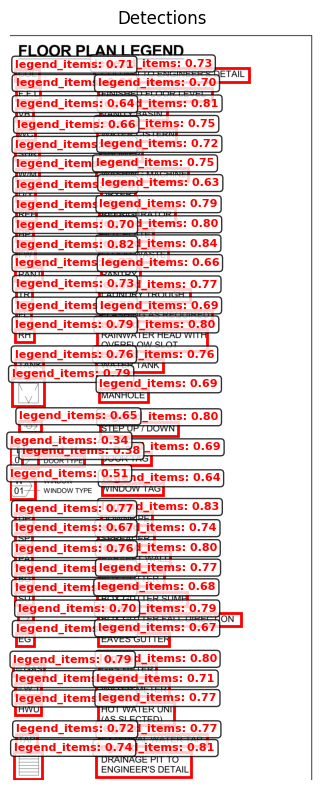

Original detections: 66
After NMS: 63
Removed: 3 (4.5%)
     method  filtered_count  removal_rate
   standard              64      0.030303
   adaptive              64      0.030303
       soft              65      0.015152
class_aware              64      0.030303

ADVANCED NMS METHODS:
------------------------------
Adaptive NMS: 66 -> 64 detections


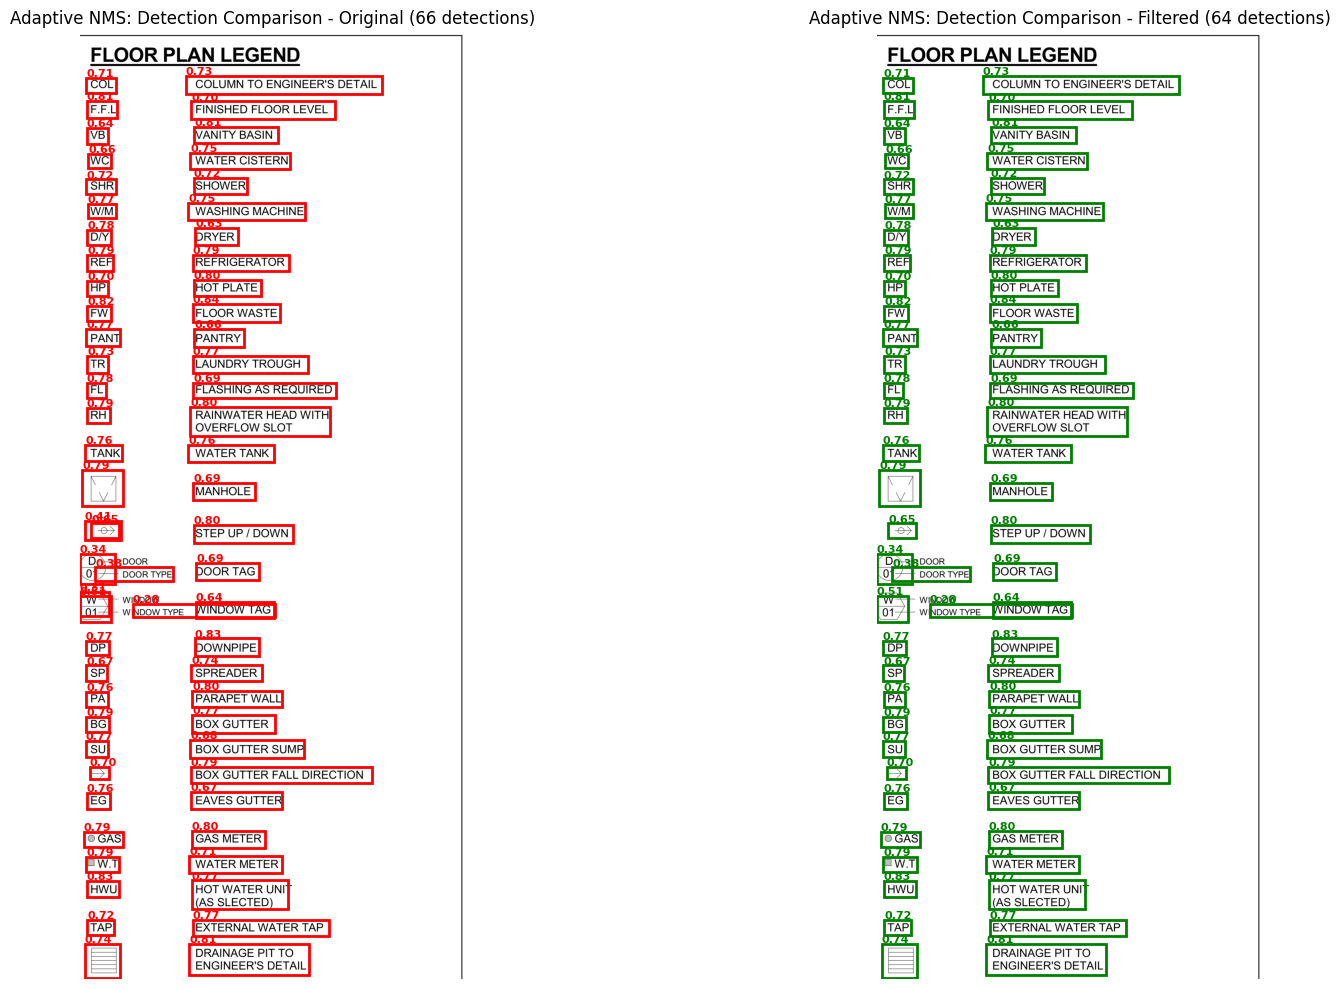

Soft NMS: 66 -> 65 detections
Class-aware NMS: 66 -> 64 detections


In [ ]:
# Process a single JSON file
# file_name = "Architectural Drawings 020520_22_0"
# file_name = "camp-3-part-10-plans-drawings_43_0"
# file_name = "60492284-DRG-EL-5001-T4_1_1" # distribution
# file_name = "60492284-DRG-EL-5001-T4_1_5" # luminaries
file_name = "28 St Clems Rd Doncaster East - Working Drawings_3_0"
json_file = f"/Users/shenghan/Code/scopeiq-ai-backend/train/results/round-4/{file_name}_pred.json"
image_file = f"/Users/shenghan/Code/scopeiq-ai-backend/train/export_round2/{file_name}.png"

# Apply standard NMS
filtered_detections, stats = process_json_file_with_nms(
    json_file, image_file, iou_threshold=0.4, score_threshold=0.3, class_agnostic=False
)

print(f"Original detections: {stats['original_count']}")
print(f"After NMS: {stats['filtered_count']}")
print(f"Removed: {stats['removed_count']} ({stats['removal_rate']:.1%})")

# Example 2: Compare different NMS methods
method_comparison = compare_nms_methods(json_file)
print(
    method_comparison[["method", "filtered_count", "removal_rate"]].to_string(
        index=False
    )
)

# Example 3: Batch processing
# print("\n3. BATCH PROCESSING EXAMPLE:")
# print("-" * 30)

# # Process all JSON files in a directory
# input_dir = "/Users/shenghan/Code/scopeiq-ai-backend/train/results/round-4"
# output_dir = "/Users/shenghan/Code/scopeiq-ai-backend/train/results/round-4-nms"

# # Create output directory
# Path(output_dir).mkdir(parents=True, exist_ok=True)

# # Process with standard NMS
# batch_results = batch_process_json_files(
#     input_dir, output_dir, iou_threshold=0.4, score_threshold=0.3, class_agnostic=False
# )

# print(f"Processed {len(batch_results)} files")
# print(f"Average removal rate: {batch_results['removal_rate'].mean():.1%}")

# Advanced NMS methods
# Test adaptive NMS
detections = load_json_detections(json_file)
adaptive_filtered = adaptive_nms_json(
    detections, base_iou_threshold=0.5, confidence_weight=0.1
)
print(f"Adaptive NMS: {len(detections)} -> {len(adaptive_filtered)} detections")
compare_detections_side_by_side(
    image_file,
    json_file,
    json_file.replace('round-4', 'round-4-nms'),
    adaptive_filtered,
    "Adaptive NMS: Detection Comparison")


# Test soft NMS
soft_filtered = soft_nms_json(
    detections, iou_threshold=0.5, sigma=0.5, score_threshold=0.2
)
print(f"Soft NMS: {len(detections)} -> {len(soft_filtered)} detections")

# Test class-aware NMS
class_aware_filtered = class_aware_nms_json(
    detections, iou_threshold=0.5, score_threshold=0.2, class_penalty=0.1
)
print(f"Class-aware NMS: {len(detections)} -> {len(class_aware_filtered)} detections")

### 2.2 Row grouping

In [ ]:
@dataclass
class Box:
    x1: float
    y1: float
    x2: float
    y2: float
    confidence: Optional[float] = None
    row_num: Optional[int] = None
    macro_col_num: Optional[int] = None
    sub_col_num: Optional[int] = None
    meta: Optional[dict] = None


def _y_overlap(a: Tuple[float, float], b: Tuple[float, float]) -> float:
    """Pixel overlap along y between intervals a and b: (y1,y2)."""
    return max(0.0, min(a[1], b[1]) - max(a[0], b[0]))


def cluster_rows(
    boxes: Iterable[Box],
    tau: float = 0.45,  # overlap threshold as a fraction of median height
    sort_within_row: bool = True,  # left->right ordering inside each row
) -> List[List[Box]]:
    """
    Group boxes into rows by y-overlap. Two boxes belong to the same row
    if their y-overlap with the row band is >= tau * median_height.
    After grouping, assigns row_num to each Box (1-based index, top to bottom).
    """
    boxes = list(boxes)
    if not boxes:
        return []

    # Convert to array for fast ops
    arr = np.array([[b.x1, b.y1, b.x2, b.y2] for b in boxes], dtype=float)
    heights = arr[:, 3] - arr[:, 1]
    med_h = float(np.median(heights))
    if med_h <= 0:
        # Degenerate; fall back to each box as its own row
        for idx, b in enumerate(boxes):
            b.row_num = idx + 1
        return [[b] for b in boxes]

    # Sort by vertical center for stable greedy assignment
    y_centers = (arr[:, 1] + arr[:, 3]) * 0.5
    order = np.argsort(y_centers)
    boxes_sorted = [boxes[i] for i in order]
    arr_sorted = arr[order]

    rows: List[List[Box]] = []
    bands: List[Tuple[float, float]] = []  # running [ymin, ymax] band per row

    # This keeps track of which row/band each box is assigned to, in pre-sorted order
    for b, a in zip(boxes_sorted, arr_sorted):
        y_interval = (a[1], a[3])
        placed = False

        # Try to fit into an existing row band
        for ridx, (band_min, band_max) in enumerate(bands):
            ov = _y_overlap((band_min, band_max), y_interval)
            if ov >= tau * med_h:
                rows[ridx].append(b)
                # expand the band slightly to accommodate this box
                new_min = min(band_min, y_interval[0])
                new_max = max(band_max, y_interval[1])
                bands[ridx] = (new_min, new_max)
                placed = True
                break

        # If no row band matches, start a new row
        if not placed:
            rows.append([b])
            bands.append(y_interval)

    # Remove orphaned elements in row detection - rows with only 1 box
    print(f"Before removing orphaned elements: {len(rows)} rows")
    rows = [row for row in rows if len(row) > 1]
    print(f"After removing orphaned elements: {len(rows)} rows")

    # Optional: order elements inside each row left->right
    if sort_within_row:
        for r in rows:
            r.sort(key=lambda bb: (bb.x1 + bb.x2) * 0.5)

    # Final: sort rows from top to bottom by their band center
    row_keys = [(mn + mx) * 0.5 for (mn, mx) in bands]
    # Also keep track of the permutation so we can map to row_nums
    pairs = list(sorted(zip(row_keys, rows), key=lambda t: t[0]))
    sorted_rows = [r for _, r in pairs]

    # Assign row_num to each Box object (1-based, top to bottom)
    for row_idx, row in enumerate(sorted_rows, 1):
        for b in row:
            b.row_num = row_idx

    return sorted_rows

In [234]:
# convert to box objects
box_objects = []
for detection in filtered_detections:
    box_objects.append(Box(
        x1=detection['box']['x1'],
        y1=detection['box']['y1'],
        x2=detection['box']['x2'],
        y2=detection['box']['y2'],
        confidence=detection['confidence']
    ))

rows = cluster_rows(box_objects, tau=0.45)
for i, row in enumerate(rows, 1):
    print(f"Row {i}: {[ (b.x1,b.y1,b.x2,b.y2) for b in row ]}")

Before removing orphaned elements: 31 rows
After removing orphaned elements: 31 rows
Row 1: [(18.13477, 131.99161, 104.03217, 175.62091), (302.84116, 127.43554, 863.77173, 179.16759)]
Row 2: [(19.42488, 198.38675, 106.65885, 245.94389), (317.92145, 199.39229, 729.46704, 249.34393)]
Row 3: [(19.97291, 274.94153, 81.43913, 320.20209), (326.83682, 272.47473, 567.76721, 318.49146)]
Row 4: [(24.59899, 349.90417, 89.28863, 390.33762), (315.3667, 346.75238, 601.27228, 393.2536)]
Row 5: [(19.04988, 422.52274, 102.8323, 463.45255), (326.05835, 418.95923, 478.06577, 464.08295)]
Row 6: [(22.79613, 492.87183, 104.69795, 534.19415), (310.60196, 489.43591, 644.93561, 539.3905)]
Row 7: [(21.75772, 566.77008, 88.99204, 610.89679), (329.53488, 560.82855, 452.23657, 610.11078)]
Row 8: [(21.59208, 638.0899, 93.61765, 683.40503), (323.02875, 637.34735, 597.82135, 685.19977)]
Row 9: [(21.3341, 712.64838, 81.27373, 755.35016), (325.8374, 710.19629, 518.77283, 756.56714)]
Row 10: [(20.64882, 783.93134, 90.01

/var/folders/lr/whd5k7vx6456g3_crvsy8hdm0000gn/T/ipykernel_42480/1409197283.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap('tab20', n_rows)


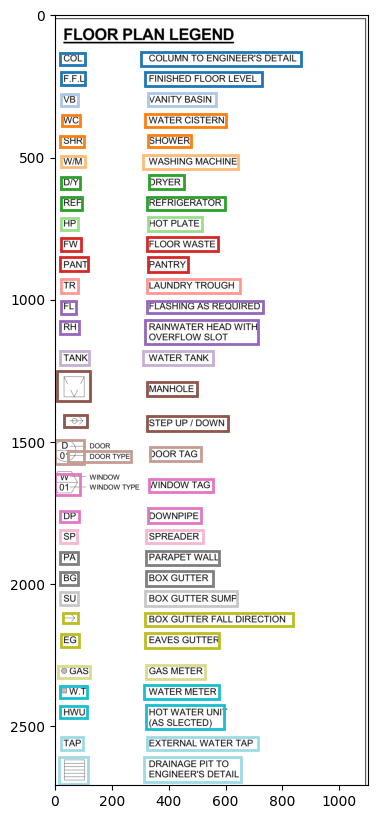

In [235]:
# visualise identified rows
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_rows(image_path, rows):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import matplotlib.cm as cm
    import numpy as np

    # Load image
    image = plt.imread(image_path)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)

    # Each row gets its own color
    n_rows = len(rows)
    color_map = cm.get_cmap('tab20', n_rows)
    
    for i, row in enumerate(rows):
        color = color_map(i)
        # Draw each individual bounding box for this row in the same color
        for b in row:
            x1, y1, x2, y2 = b.x1, b.y1, b.x2, b.y2
            width = x2 - x1
            height = y2 - y1
            rect = patches.Rectangle(
                (x1, y1), width, height,
                linewidth=2, edgecolor=color, facecolor='none'
            )
            ax.add_patch(rect)
        
    plt.show()

visualize_rows(image_file, rows)


### 2.3 Column detection

In [222]:
from dataclasses import dataclass
from typing import List, Tuple, Optional, Dict
import numpy as np

def _xcenters(boxes: List[Box]) -> np.ndarray:
    return np.array([(b.x1 + b.x2) * 0.5 for b in boxes], dtype=float).reshape(-1, 1)


def infer_macro_and_subcolumns(
    boxes: List[Box],
    is_text_mask: Optional[List[bool]] = None,
    k_sub_max: int = 8,  # maximum number of sub-columns to try
    roi_width: Optional[float] = None,
    min_support_per_sub: int = 2,  # at least this many boxes per sub-column
    min_center_gap_frac: float = 0.05,  # adjacent sub-centers must differ by >= 5% ROI width
) -> Tuple[int, np.ndarray, Dict[int, Tuple[int, int]]]:
    """
    Returns:
      n_macro                      : number of macro-columns inferred (>=1)
      sub_centers_sorted (M,)      : x-centers of sub-columns (M = 2 * n_macro), left→right
      assign[i] -> (macro_id, sub_id) for box i, where sub_id ∈ {0,1} (0=left sub, 1=right sub)
    Additionally, assigns macro_col_num and sub_col_num attributes to each Box object.
    Only includes boxes where row_num is not None.
    """
    # --- Only include boxes where row_num is not None ---
    filtered = [(i, b) for i, b in enumerate(boxes) if getattr(b, "row_num", None) is not None]
    if not filtered:
        # No boxes with row_num, trivial fallback (return empty result)
        return 0, np.array([]), {}

    filtered_indices, filtered_boxes = zip(*filtered)
    idx_all = np.arange(len(filtered_boxes))

    # Optionally filter is_text_mask if it was provided
    filtered_is_text_mask = None
    if is_text_mask is not None:
        filtered_is_text_mask = [is_text_mask[i] for i in filtered_indices]
    if filtered_is_text_mask is not None and any(filtered_is_text_mask):
        base_idx = np.array([i for i, m in enumerate(filtered_is_text_mask) if m], dtype=int)
    else:
        base_idx = idx_all

    if len(base_idx) < 2:
        # trivial: 1 macro, 2 sub-columns at median split
        xc_all = _xcenters(filtered_boxes).flatten()
        thr = float(np.median(xc_all)) if len(xc_all) else 0.0
        sub_centers = (
            np.array([np.min(xc_all), np.max(xc_all)])
            if len(xc_all)
            else np.array([0.25, 0.75])
        )
        assign = {}
        for idx, bxc in enumerate(xc_all):
            macro = 0
            sub = 0 if bxc <= thr else 1
            assign[filtered_indices[idx]] = (macro, sub)
            # Set macro_col_num and sub_col_num on the Box object (original, not filtered)
            boxes[filtered_indices[idx]].macro_col_num = macro
            boxes[filtered_indices[idx]].sub_col_num = sub
        return 1, np.sort(sub_centers), assign

    X = _xcenters([filtered_boxes[i] for i in base_idx])

    # --- 1) discover an even number of sub-columns via BIC (2,4,6,...) ---
    best = {"bic": np.inf, "k_sub": 2, "labels": None, "centers": None}
    tried_any = False
    try:
        from sklearn.mixture import GaussianMixture

        for k_sub in range(2, min(k_sub_max, len(X)) + 1, 2):
            gmm = GaussianMixture(
                n_components=k_sub, covariance_type="full", random_state=42
            )
            gmm.fit(X)
            bic = gmm.bic(X)
            centers = np.sort(gmm.means_.flatten())
            # sanity checks: center spacing & support
            ok = True
            if roi_width is not None and k_sub > 1:
                gaps = np.diff(centers) / max(roi_width, 1.0)
                if np.any(gaps < min_center_gap_frac):
                    ok = False
            labels = gmm.predict(X)
            counts = np.array([np.sum(labels == j) for j in range(k_sub)])
            if np.any(counts < min_support_per_sub):
                ok = False
            if ok and bic < best["bic"]:
                best = {
                    "bic": bic,
                    "k_sub": k_sub,
                    "labels": labels,
                    "centers": centers,
                }
                tried_any = True
    except Exception:
        tried_any = False  # fallback below

    if not tried_any:
        # histogram fallback to 2 sub-columns
        xc = X.flatten()
        thr = np.median(xc)
        centers = np.array([np.median(xc[xc <= thr]), np.median(xc[xc > thr])])
        best = {"k_sub": 2, "centers": np.sort(centers)}

    k_sub = best["k_sub"]
    sub_centers = best["centers"]  # sorted left→right

    # --- 2) pair adjacent sub-columns into macro-columns using GAP clustering ---
    # small gap -> within same macro; large gap -> macro boundary
    gaps = np.diff(sub_centers)
    if len(gaps) == 0:
        gap_thr = np.inf
    else:
        # Otsu-like split on gaps (or kmeans on 1D gaps)
        try:
            from sklearn.cluster import KMeans

            km = KMeans(n_clusters=2, n_init=10, random_state=42).fit(
                gaps.reshape(-1, 1)
            )
            centers_gap = km.cluster_centers_.flatten()
            gap_thr = float(
                np.mean(centers_gap)
            )  # mid-point between small/large clusters
        except Exception:
            # percentile fallback
            gap_thr = float(np.percentile(gaps, 75))

    # walk through centers and form pairs
    pairs = []
    i = 0
    while i < len(sub_centers) - 1:
        # if the next gap is "small", treat (i, i+1) as a pair; else force a pair anyway (robustness)
        pairs.append((i, i + 1))
        i += 2

    n_macro = len(pairs)

    # --- 3) assign every box to nearest sub-center, then map to (macro_id, sub_id) ---
    all_xc = _xcenters(boxes).flatten()
    nearest_sub = np.argmin(np.abs(all_xc[:, None] - sub_centers[None, :]), axis=1)
    # build sub -> (macro_id, sub_id) map
    sub_to_pair: Dict[int, Tuple[int, int]] = {}
    for mid, (li, ri) in enumerate(pairs):
        sub_to_pair[li] = (mid, 0)  # left sub
        sub_to_pair[ri] = (mid, 1)  # right sub

    assign: Dict[int, Tuple[int, int]] = {}
    # Only iterate over filtered boxes, not all boxes
    for idx_in_filtered, filtered_idx in enumerate(filtered_indices):
        s = nearest_sub[filtered_idx]  # Get the nearest sub for this specific box
        # clamp in case k_sub < 2 (shouldn't happen with above logic)
        s = int(np.clip(s, 0, len(sub_centers) - 1))
        # if odd leftover, map last sub to the closest existing pair
        if s not in sub_to_pair:
            # attach to the nearest existing sub (rare)
            alt = int(np.argmin(np.abs(sub_centers - sub_centers[s])))
            assign[filtered_idx] = sub_to_pair.get(alt, (0, 0))
            macro, sub = assign[filtered_idx]
            boxes[filtered_idx].macro_col_num = macro
            boxes[filtered_idx].sub_col_num = sub
        else:
            assign[filtered_idx] = sub_to_pair[s]
            macro, sub = assign[filtered_idx]
            boxes[filtered_idx].macro_col_num = macro
            boxes[filtered_idx].sub_col_num = sub

    return n_macro, sub_centers, assign


def visualize_boxes_with_row_and_columns(image_path, box_objects):
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import matplotlib.cm as cm
    import numpy as np

    # Load image
    image = plt.imread(image_path)
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(image)

    # Get all row_nums to determine unique rows and assign colors accordingly
    row_nums = [getattr(b, "row_num", -1) for b in box_objects]
    unique_rows = sorted(set(r for r in row_nums if r is not None and r != -1))
    n_rows = len(unique_rows)
    color_map = cm.get_cmap("tab20", n_rows if n_rows > 0 else 1)
    row_to_color = {row: color_map(i) for i, row in enumerate(unique_rows)}

    for b in box_objects:
        x1, y1, x2, y2 = b.x1, b.y1, b.x2, b.y2
        width = x2 - x1
        height = y2 - y1
        row = getattr(b, "row_num", -1)
        color = row_to_color.get(row, (0, 0, 0, 1))  # fallback to black

        rect = patches.Rectangle(
            (x1, y1), width, height, linewidth=2, edgecolor=color, facecolor="none"
        )
        ax.add_patch(rect)

        # Get macro_col_num and sub_col_num for labeling
        macro_col = getattr(b, "macro_col_num", "")
        sub_col = getattr(b, "sub_col_num", "")

        # --- New logic for label (sub_col 0: sym, sub_col 1: desc) ---
        if macro_col == "" and sub_col == "":
            label = ""
        else:
            if sub_col == 0:
                sub_label = "sym"
            elif sub_col == 1:
                sub_label = "desc"
            elif sub_col == "":
                sub_label = "?"
            else:
                sub_label = str(sub_col)
            if macro_col == "":
                if sub_col != "":
                    label = f"?{sub_label}"
                else:
                    label = ""
            else:
                label = f"{macro_col},{sub_label}"

        if label:
            ax.text(x1, y1 - 5, f"{label}", color=color, fontsize=9, weight="bold")

    plt.show()

Macro-columns: 1
Sub-column centers (x): [178.96305400000173, 856.3051716666663]
0 -> no row_num, skipped (502.52557, 1168.23511, 932.76605, 1314.68689)
1 -> macro 0 sub 1 (477.37515, 695.323, 1357.0824, 840.94409)
2 -> macro 0 sub 1 (434.42575, 919.95868, 1206.79456, 1070.80005)
3 -> no row_num, skipped (45.58185, 247.12357, 483.91022, 301.28555)
4 -> macro 0 sub 1 (467.24387, 421.53137, 1194.9093, 594.97217)
5 -> macro 0 sub 0 (37.60204, 680.61047, 517.4408, 818.755)
6 -> no row_num, skipped (510.172, 197.71542, 997.75867, 349.30502)
7 -> macro 0 sub 0 (78.34946, 526.20935, 147.72443, 593.49194)
8 -> macro 0 sub 0 (57.0958, 440.33463, 175.99437, 544.26428)
9 -> macro 0 sub 0 (37.48314, 915.98169, 513.74707, 1072.08459)
10 -> no row_num, skipped (7.98051, 142.01212, 53.0489, 197.02055)
11 -> no row_num, skipped (7.92043, 1150.15564, 50.77758, 1211.71838)
12 -> macro 0 sub 0 (75.94077, 1003.3299, 148.25266, 1090.65942)


/var/folders/lr/whd5k7vx6456g3_crvsy8hdm0000gn/T/ipykernel_42480/370063690.py:186: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap("tab20", n_rows if n_rows > 0 else 1)


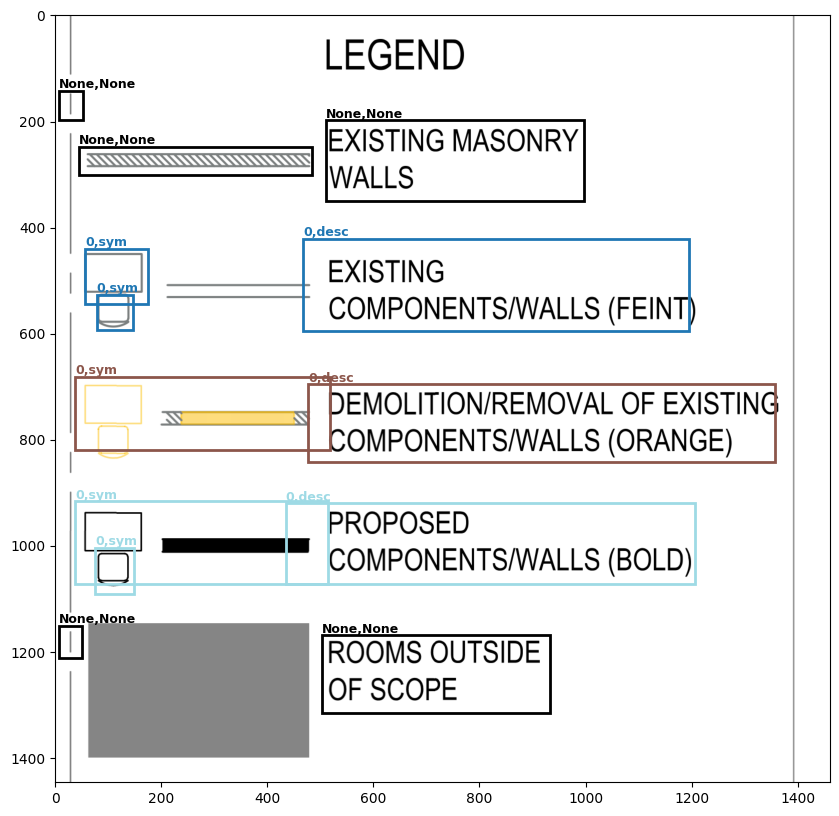

In [225]:
# boxes: all detections (icons + text) inside ONE legend ROI
# is_text_mask: optional list[bool] same length as boxes (True for text), improves sub-column discovery
legend_width_pixels = plt.imread(image_file).shape[1]
n_macro, sub_centers, assign = infer_macro_and_subcolumns(
    box_objects,
    is_text_mask=None,  # or None
    k_sub_max=8,  # supports up to 4 macro-columns (8 sub-columns); raise if needed
    roi_width=legend_width_pixels,  # improves spacing sanity checks
)

print("Macro-columns:", n_macro)
print("Sub-column centers (x):", sub_centers.tolist())

# Every box now has (macro_id, sub_id in {0,1})
for i, b in enumerate(box_objects):
    if i in assign:
        print(
            i, "-> macro", assign[i][0], "sub", assign[i][1], (b.x1, b.y1, b.x2, b.y2)
        )
    else:
        print(i, "-> no row_num, skipped", (b.x1, b.y1, b.x2, b.y2))
        
visualize_boxes_with_row_and_columns(image_file, box_objects)

### Stage 2 post-processing pipeline

- TODO: Combine left side symbols if they're contagious
- TODO: Export symbols for Stage 3
- Plan productionising this pipeline - 

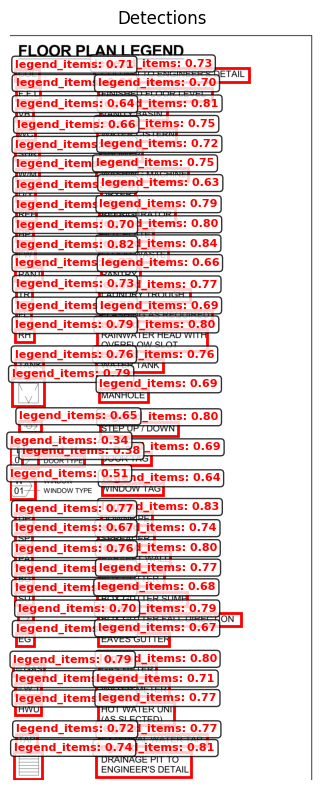

Original detections: 66
After NMS: 63
Removed: 3 (4.5%)
Before removing orphaned elements: 31 rows
After removing orphaned elements: 31 rows
Row 1: [(18.13477, 131.99161, 104.03217, 175.62091), (302.84116, 127.43554, 863.77173, 179.16759)]
Row 2: [(19.42488, 198.38675, 106.65885, 245.94389), (317.92145, 199.39229, 729.46704, 249.34393)]
Row 3: [(19.97291, 274.94153, 81.43913, 320.20209), (326.83682, 272.47473, 567.76721, 318.49146)]
Row 4: [(24.59899, 349.90417, 89.28863, 390.33762), (315.3667, 346.75238, 601.27228, 393.2536)]
Row 5: [(19.04988, 422.52274, 102.8323, 463.45255), (326.05835, 418.95923, 478.06577, 464.08295)]
Row 6: [(22.79613, 492.87183, 104.69795, 534.19415), (310.60196, 489.43591, 644.93561, 539.3905)]
Row 7: [(21.75772, 566.77008, 88.99204, 610.89679), (329.53488, 560.82855, 452.23657, 610.11078)]
Row 8: [(21.59208, 638.0899, 93.61765, 683.40503), (323.02875, 637.34735, 597.82135, 685.19977)]
Row 9: [(21.3341, 712.64838, 81.27373, 755.35016), (325.8374, 710.19629, 518

/var/folders/lr/whd5k7vx6456g3_crvsy8hdm0000gn/T/ipykernel_42480/370063690.py:186: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = cm.get_cmap("tab20", n_rows if n_rows > 0 else 1)


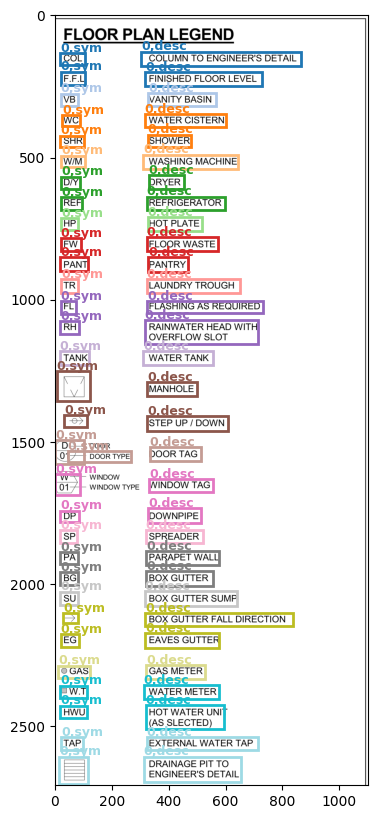

Saved 63 boxes to /Users/shenghan/Code/scopeiq-ai-backend/train/results/round-4-processed/28 St Clems Rd Doncaster East - Working Drawings_3_0_pred.json


In [241]:
# file_name = "Architectural Drawings 020520_22_0"
# file_name = "camp-3-part-10-plans-drawings_43_0"
# file_name = "60492284-DRG-EL-5001-T4_1_1" # distribution
# file_name = "60492284-DRG-EL-5001-T4_1_5" # luminaries
file_name = "28 St Clems Rd Doncaster East - Working Drawings_3_0"
json_file = f"/Users/shenghan/Code/scopeiq-ai-backend/train/results/round-4/{file_name}_pred.json"
image_file = (
    f"/Users/shenghan/Code/scopeiq-ai-backend/train/export_round2/{file_name}.png"
)

# Apply standard NMS
filtered_detections, stats = process_json_file_with_nms(
    json_file, image_file, iou_threshold=0.4, score_threshold=0.3, class_agnostic=False
)

print(f"Original detections: {stats['original_count']}")
print(f"After NMS: {stats['filtered_count']}")
print(f"Removed: {stats['removed_count']} ({stats['removal_rate']:.1%})")

## ROW GROUPING
# convert to box objects
box_objects = []
for detection in filtered_detections:
    box_objects.append(
        Box(
            x1=detection["box"]["x1"],
            y1=detection["box"]["y1"],
            x2=detection["box"]["x2"],
            y2=detection["box"]["y2"],
            confidence=detection['confidence']
        )
    )

rows = cluster_rows(box_objects, tau=0.45)
for i, row in enumerate(rows, 1):
    print(f"Row {i}: {[ (b.x1,b.y1,b.x2,b.y2) for b in row ]}")

## COLUMN DETECTION
# boxes: all detections (icons + text) inside ONE legend ROI
# is_text_mask: optional list[bool] same length as boxes (True for text), improves sub-column discovery
legend_width_pixels = plt.imread(image_file).shape[1]
n_macro, sub_centers, assign = infer_macro_and_subcolumns(
    box_objects,
    is_text_mask=None,  # or None
    k_sub_max=8,  # supports up to 4 macro-columns (8 sub-columns); raise if needed
    roi_width=legend_width_pixels,  # improves spacing sanity checks
)

print("Macro-columns:", n_macro)
print("Sub-column centers (x):", sub_centers.tolist())

# Every box now has (macro_id, sub_id in {0,1})
for i, b in enumerate(box_objects):
    if i in assign:
        print(
            i, "-> macro", assign[i][0], "sub", assign[i][1], (b.x1, b.y1, b.x2, b.y2)
        )
    else:
        print(i, "-> no row_num, skipped", (b.x1, b.y1, b.x2, b.y2))

visualize_boxes_with_row_and_columns(image_file, box_objects)

## SAVE RESULTS
OUTPUT_DIR = Path(json_file).parent.parent / "round-4-processed"
output_json_path = OUTPUT_DIR / (Path(json_file).stem + ".json")

# Prepare a list of box dicts (for JSON serializable)
box_dicts = [vars(b) for b in box_objects]

# Write to the JSON file
with open(output_json_path, "w") as f:
    json.dump(box_dicts, f, indent=2)

print(f"Saved {len(box_dicts)} boxes to {output_json_path}")

In [ ]:
def organise_legend_data(box_dicts):
    """
    Organise box_dicts into 2D list by macro col num, and then row num
    macro_col -> row_num -> symbol/description
    """
    legend_data = {}
    for box in box_dicts:
        macro_col = box.macro_col_num
        row_num = box.row_num
        if macro_col not in legend_data:
            legend_data[macro_col] = {}
        if row_num:
            if row_num not in legend_data[macro_col]:
                legend_data[macro_col][row_num] = {}
            if box.sub_col_num == 0:
                legend_data[macro_col][row_num]["symbol"] = box
            elif box.sub_col_num == 1:
                legend_data[macro_col][row_num]["description"] = box

    # convert legend_data into 2D list
    legend_data_2d = []
    for macro_col in sorted(legend_data.keys()):
        row_data = []   
        for row_num in sorted(legend_data[macro_col].keys()):
            row_data.append(legend_data[macro_col][row_num])
        print(f"Rows found: {len(row_data)}")
        legend_data_2d.append(row_data)
    print(f"Total columns: {len(legend_data_2d)}")
    return legend_data_2d

Read 63 boxes from /Users/shenghan/Code/scopeiq-ai-backend/train/results/round-4-processed/28 St Clems Rd Doncaster East - Working Drawings_3_0_pred.json
Rows found: 31
Total columns: 1


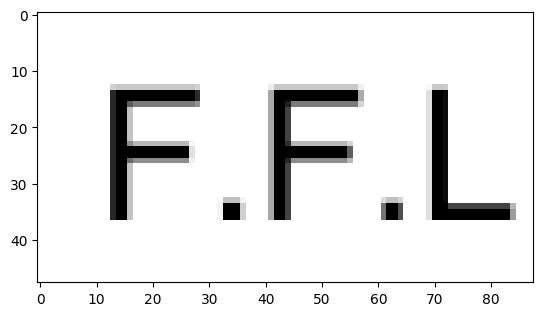

Saved cropped symbol to /Users/shenghan/Code/scopeiq-ai-backend/train/results/round-4-processed/cropped/28 St Clems Rd Doncaster East - Working Drawings_3_0_0_1_symbol.png


In [300]:
# grab one symbol and description pair
file_name = "28 St Clems Rd Doncaster East - Working Drawings_3_0"
json_file = f"/Users/shenghan/Code/scopeiq-ai-backend/train/results/round-4-processed/{file_name}_pred.json"
image_file = (
    f"/Users/shenghan/Code/scopeiq-ai-backend/train/export_round2/{file_name}.png"
)

with open(json_file, "r") as f:
    box_dicts = json.load(f)

processed_boxes = [Box(**d) for d in box_dicts]

print(f"Read {len(processed_boxes)} boxes from {json_file}")

legend_data_2d = organise_legend_data(processed_boxes)

col_idx = 0
row_idx = 1
box_obj = legend_data_2d[col_idx][row_idx]
symbol_obj = box_obj['symbol']
description_obj = box_obj['description']

# read image crop bbox from image
image = plt.imread(image_file)
x1, y1, x2, y2 = round(symbol_obj.x1), round(symbol_obj.y1), round(symbol_obj.x2), round(symbol_obj.y2)
cropped_image = image[y1:y2, x1:x2]

# show cropped image
plt.imshow(cropped_image)
plt.show()

# optional save cropped symbol
symbol_crop_path = Path(json_file).parent.parent / "round-4-processed" / "cropped" / f"{file_name}_{col_idx}_{row_idx}_symbol.png"
plt.imsave(symbol_crop_path, cropped_image)
print(f"Saved cropped symbol to {symbol_crop_path}")

In [298]:
print(box_obj)

{'symbol': Box(x1=19.42488, y1=198.38675, x2=106.65885, y2=245.94389, confidence=0.81457, row_num=2, macro_col_num=0, sub_col_num=0, meta=None), 'description': Box(x1=317.92145, y1=199.39229, x2=729.46704, y2=249.34393, confidence=0.69516, row_num=2, macro_col_num=0, sub_col_num=1, meta=None)}


## Scratchpad

In [34]:
import os

def strip_first_x_chars_from_filenames(dir_path, x):
    for filename in os.listdir(dir_path):
        old_path = os.path.join(dir_path, filename)
        # Skip if not a file
        if not os.path.isfile(old_path):
            continue
        new_filename = filename[x:]
        if new_filename == filename or not new_filename:
            continue  # Don't rename if result is same or empty
        new_path = os.path.join(dir_path, new_filename)
        os.rename(old_path, new_path)
        print(f"Renamed: {filename} -> {new_filename}")

# Example usage:
strip_first_x_chars_from_filenames(
    "/Users/shenghan/Code/scopeiq-ai-backend/train/export_round2_1", 9
)

Renamed: 35134da1-60492284-DRG-EL-5001-T4_1_8.png -> 60492284-DRG-EL-5001-T4_1_8.png
Renamed: 9dda1786-17_Cappella_St_Balwyn_North_-_Endorsed_Plans_5_1.png -> 17_Cappella_St_Balwyn_North_-_Endorsed_Plans_5_1.png
Renamed: 66f09226-Brightgreen_Lighting_Layout_2_1.png -> Brightgreen_Lighting_Layout_2_1.png
Renamed: 24d6f690-Brightgreen_Lighting_Layout_1_1.png -> Brightgreen_Lighting_Layout_1_1.png
Renamed: d6e3cc5c-Architectural_Drawings_020520_3_0.png -> Architectural_Drawings_020520_3_0.png
Renamed: 4417a477-28_St_Clems_Rd_Doncaster_East_-_Working_Drawings_29_1.png -> 28_St_Clems_Rd_Doncaster_East_-_Working_Drawings_29_1.png
Renamed: 526e6550-2018950_CURRENT_ECP1of2_REV_A_WITH_ENERGY_STAMP_-_141_CHARLES_ST_NORTH_BicW3H9.png -> 2018950_CURRENT_ECP1of2_REV_A_WITH_ENERGY_STAMP_-_141_CHARLES_ST_NORTH_BicW3H9.png
Renamed: feba6188-60492284-DRG-HY-1307-T2_1_0.png -> 60492284-DRG-HY-1307-T2_1_0.png
Renamed: 63a50bc2-60492284-DRG-EL-5001-T4_1_4.png -> 60492284-DRG-EL-5001-T4_1_4.png
Renamed: 0c

In [38]:
import os

def set_first_character_zero_yolo_txts(dir_path):
    total_lines = 0
    for fname in os.listdir(dir_path):
        if fname.endswith('.txt'):
            file_path = os.path.join(dir_path, fname)
            with open(file_path, 'r') as f:
                lines = f.readlines()
            total_lines += len(lines)
            new_lines = []
            for line in lines:
                line = line.rstrip('\n')
                if not line.strip():
                    new_lines.append(line)
                    continue
                # Replace the first character with '0', keep rest (including spaces)
                first_space = line.find(' ')
                if first_space == -1:
                    # Edge: no space found, treat as single number
                    new_line = '0'
                else:
                    new_line = '0' + line[first_space:]
                new_lines.append(new_line)
            with open(file_path, 'w') as f:
                for l in new_lines:
                    f.write(l + '\n')
            print(f"Updated {fname}")
    return total_lines

# Example usage:
set_first_character_zero_yolo_txts(
    "/Users/shenghan/Code/scopeiq-ai-backend/train/export_round2_1_single_cls/labels/val"
)

Updated 60492284-DRG-EL-5001-T4_1_3.txt
Updated 28 St Clems Rd Doncaster East - Working Drawings_3_1.txt
Updated Architectural_Drawings_020520_3_0.txt
Updated 28 St Clems Rd Doncaster East - Working Drawings_3_0.txt
Updated Brightgreen_Lighting_Layout_2_1.txt
Updated 28 St Clems Rd Doncaster East - Working Drawings_10_0.txt


132